### A partir de la Estacionalidad, tomamos en consideracion las fechas festivas Brasileras para evaluar la influencia de estas en la rotacion de productos.

In [1]:
import pandas as pd

In [2]:
holidays = pd.DataFrame({
    'holiday': 'brazil',
    'ds': pd.to_datetime([
      '2017-02-28', '2018-02-13',  # Carnaval
      '2017-04-14', '2018-03-30',  # Viernes Santo
      '2017-09-07', '2018-09-07',  # Independencia
      '2017-10-12', '2018-10-12',  # Nuestra Sra. Aparecida
      '2017-11-02', '2018-11-02',  # Todos los Santos
      '2017-11-15', '2018-11-15',  # Proclamación República
      '2017-11-24', '2018-11-23',  # Black Friday
      '2017-12-25', '2018-12-25'   # Navidad
        
    ]),
    'lower_window' : -1,
    'upper_window': 1, 
})

holidays

holiday         ds  lower_window  upper_window
0   brazil 2017-02-28            -1             1
1   brazil 2018-02-13            -1             1
2   brazil 2017-04-14            -1             1
3   brazil 2018-03-30            -1             1
4   brazil 2017-09-07            -1             1
5   brazil 2018-09-07            -1             1
6   brazil 2017-10-12            -1             1
7   brazil 2018-10-12            -1             1
8   brazil 2017-11-02            -1             1
9   brazil 2018-11-02            -1             1
10  brazil 2017-11-15            -1             1
11  brazil 2018-11-15            -1             1
12  brazil 2017-11-24            -1             1
13  brazil 2018-11-23            -1             1
14  brazil 2017-12-25            -1             1
15  brazil 2018-12-25            -1             1

Para obtener una prediccion robusta y elocuente, seleccionamos las categorias que tuvieron un % de dias con ventas alto (Densidad) y las ordenamos segun las cantidades vendidas por cada uno de los clasificadores de rotacion.

In [3]:
#Seleccion de Categorias con Mayor Representacion en Ventas
TopA = pd.read_csv('/workspaces/Proyecto_Final_Close-Loop-Intelligence/data/interim/TopA.csv')
TopB = pd.read_csv('/workspaces/Proyecto_Final_Close-Loop-Intelligence/data/interim/TopB.csv')
TopC = pd.read_csv('/workspaces/Proyecto_Final_Close-Loop-Intelligence/data/interim/TopC.csv')

In [4]:
TopA = TopA['Categoria Producto'].tolist()
TopB = TopB['Categoria Producto'].tolist()
TopC = TopC['Categoria Producto'].tolist()

In [5]:
#Leemos los DataFrames de las Clases para su posterior uso en la Construccion de la Serie de Tiempo
ClassA = pd.read_csv('/workspaces/Proyecto_Final_Close-Loop-Intelligence/data/interim/ClassA.csv')
ClassB = pd.read_csv('/workspaces/Proyecto_Final_Close-Loop-Intelligence/data/interim/ClassB.csv')
ClassC = pd.read_csv('/workspaces/Proyecto_Final_Close-Loop-Intelligence/data/interim/ClassC.csv')

In [6]:
#Reorganizamos cada DataFrame de Clase por Categoria para Emplear Prophet en la Construccion de la Serie de Tiempo
A = ClassA[ClassA['Categoria Producto'].str.lower().isin(TopA)].sort_values('Fecha', ascending= False).groupby(['Categoria Producto', 'Fecha'])['Cantidad'].sum().reset_index()
A.columns = ['Categoria Producto', 'ds', 'y']
B = ClassB[ClassB['Categoria Producto'].str.lower().isin(TopB)].sort_values('Fecha', ascending= False).groupby(['Categoria Producto', 'Fecha'])['Cantidad'].sum().reset_index()
B.columns = ['Categoria Producto', 'ds', 'y']
C = ClassC[ClassC['Categoria Producto'].str.lower().isin(TopC)].sort_values('Fecha', ascending= False).groupby(['Categoria Producto', 'Fecha'])['Cantidad'].sum().reset_index()
C.columns = ['Categoria Producto', 'ds', 'y']

In [7]:
A.drop_duplicates(inplace=True)
B.drop_duplicates(inplace=True)
C.drop_duplicates(inplace=True)

In [8]:
A['ds'] = pd.to_datetime(A['ds'])
B['ds'] = pd.to_datetime(B['ds'])
C['ds'] = pd.to_datetime(C['ds'])

In [9]:
#Creamos los Calendarios para cada Clase, y con ello poder definir los dias sin ventas en cada una de ellas, lo que es crucial para la correcta construccion de la Serie de Tiempo con Prophet

CalendarioA = pd.DataFrame({
    'ds': pd.date_range(start=A['ds'].min(), end=A['ds'].max(), freq='D')
})

CalendarioB = pd.DataFrame({
    'ds': pd.date_range(start=B['ds'].min(), end=B['ds'].max(), freq='D')
})

CalendarioC = pd.DataFrame({
    'ds': pd.date_range(start=C['ds'].min(), end=C['ds'].max(), freq='D')
})

In [10]:
### Definicion de las Series para cada clase considerando los dias sin ventas como Cantidad 0

SeriesA = pd.merge(CalendarioA,A, on='ds', how='left')
SeriesA['y'] = SeriesA['y'].fillna(0)

SeriesB = pd.merge(CalendarioB,B, on='ds', how='left')
SeriesB['y'] = SeriesB['y'].fillna(0)

SeriesC = pd.merge(CalendarioC,C, on='ds', how='left')
SeriesC['y'] = SeriesC['y'].fillna(0)


In [11]:
SeriesA

ds      Categoria Producto    y
0    2016-09-04        moveis_decoracao  3.0
1    2016-09-05               telefonia  1.0
2    2016-09-06                     NaN  0.0
3    2016-09-07                     NaN  0.0
4    2016-09-08                     NaN  0.0
...         ...                     ...  ...
8235 2018-08-28   utilidades_domesticas  7.0
8236 2018-08-29            beleza_saude  3.0
8237 2018-08-29           esporte_lazer  1.0
8238 2018-08-29  informatica_acessorios  1.0
8239 2018-08-29      relogios_presentes  2.0

[8240 rows x 3 columns]

In [12]:
#Definimos la Funcion de Seleccion de Categorias para Cada Clase.

def Cat_Selection(Series, Categoria):
  #Se filtra la categoria seleccionada en la serie
  SeriesCat = Series[Series['Categoria Producto'] == Categoria].copy()
  SeriesCat['ds'] = pd.to_datetime(SeriesCat['ds'])

  #Aseguramos continuidad reindexando
  SeriesCat = SeriesCat.groupby('ds').agg({'y': 'sum'}).reset_index()
  rango = pd.date_range(start=SeriesCat['ds'].min(), end=SeriesCat['ds'].max(), freq='D')
  SeriesCat = SeriesCat.set_index('ds').reindex(rango).reset_index()
  SeriesCat.columns = ['ds', 'y']

  #Imputacion de Valores
  SeriesCat['y'] = SeriesCat['y'].fillna(0)
  Series['Categoria Producto'] = Categoria


  return SeriesCat[['ds', 'y']]


# Entrenamiento del Modelo
---

### Por cascada de priorizacion, se entrenara el modelo unicamente con las unidades vendidas dentro de las categorias de mas alta rotacion en ventas

In [13]:
from prophet import Prophet
from pickle import dump
import seaborn as sns
import matplotlib.pyplot as plt

/workspaces/Proyecto_Final_Close-Loop-Intelligence/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


16:01:46 - cmdstanpy - INFO - Chain [1] start processing
16:01:47 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/12 [00:00<?, ?it/s]16:01:47 - cmdstanpy - INFO - Chain [1] start processing
16:01:47 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  9.42it/s]16:01:47 - cmdstanpy - INFO - Chain [1] start processing
16:01:47 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  6.43it/s]16:01:47 - cmdstanpy - INFO - Chain [1] start processing
16:01:47 - cmdstanpy - INFO - Chain [1] done processing
16:01:47 - cmdstanpy - INFO - Chain [1] start processing
16:01:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00,  8.16it/s]16:01:48 - cmdstanpy - INFO - Chain [1] start processing
16:01:48 - cmdstanpy - INFO - Chain [1] done processing
16:01:48 - cmdstanpy - INFO - Chain [1] start processing
16:01:48 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 6/12 [00:00<00:0

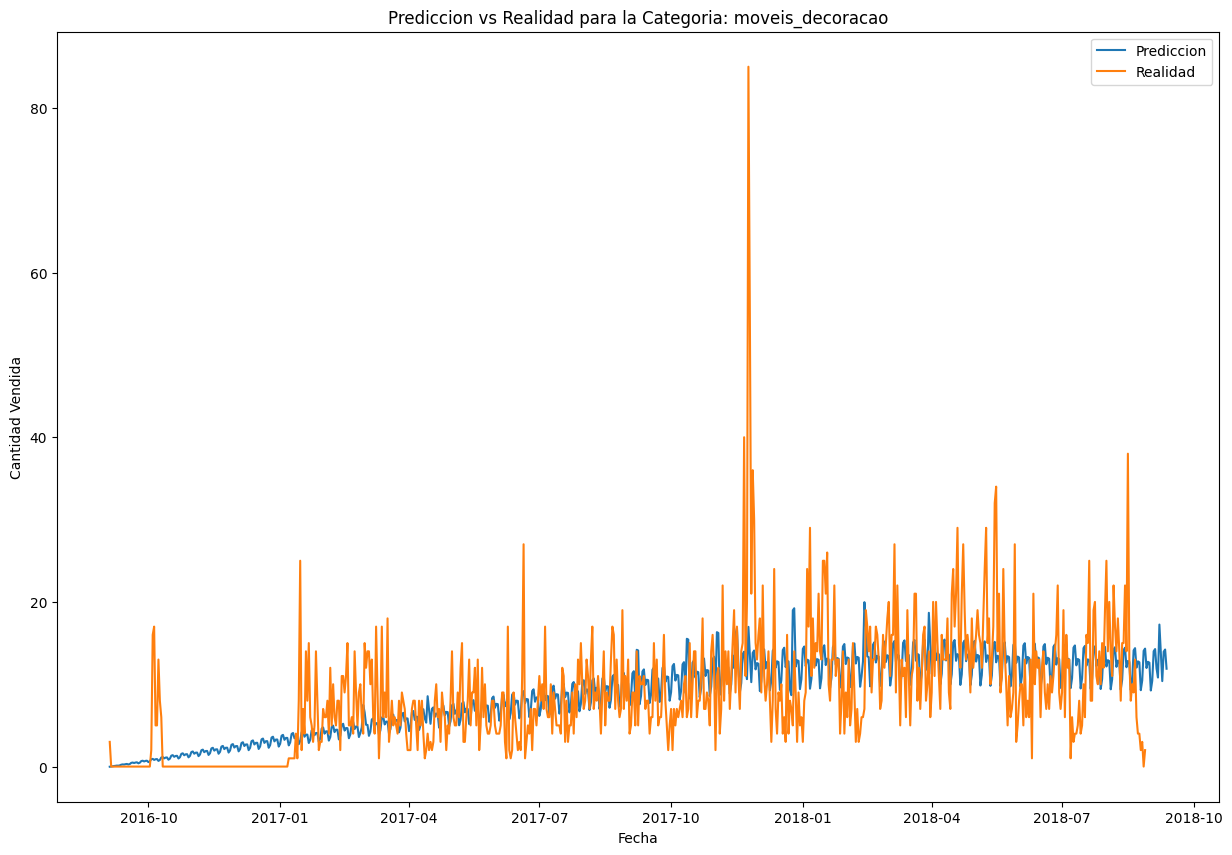

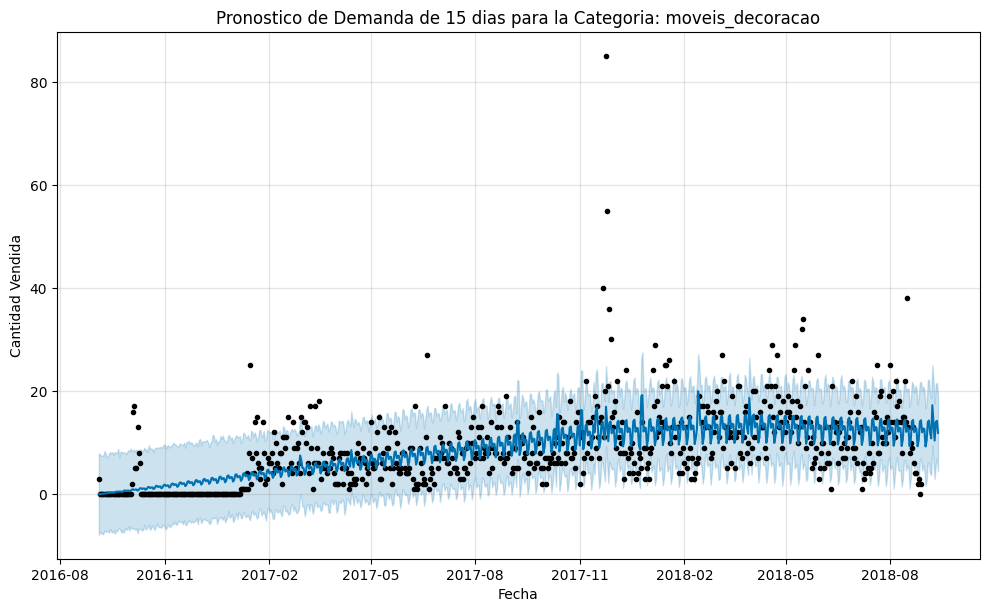

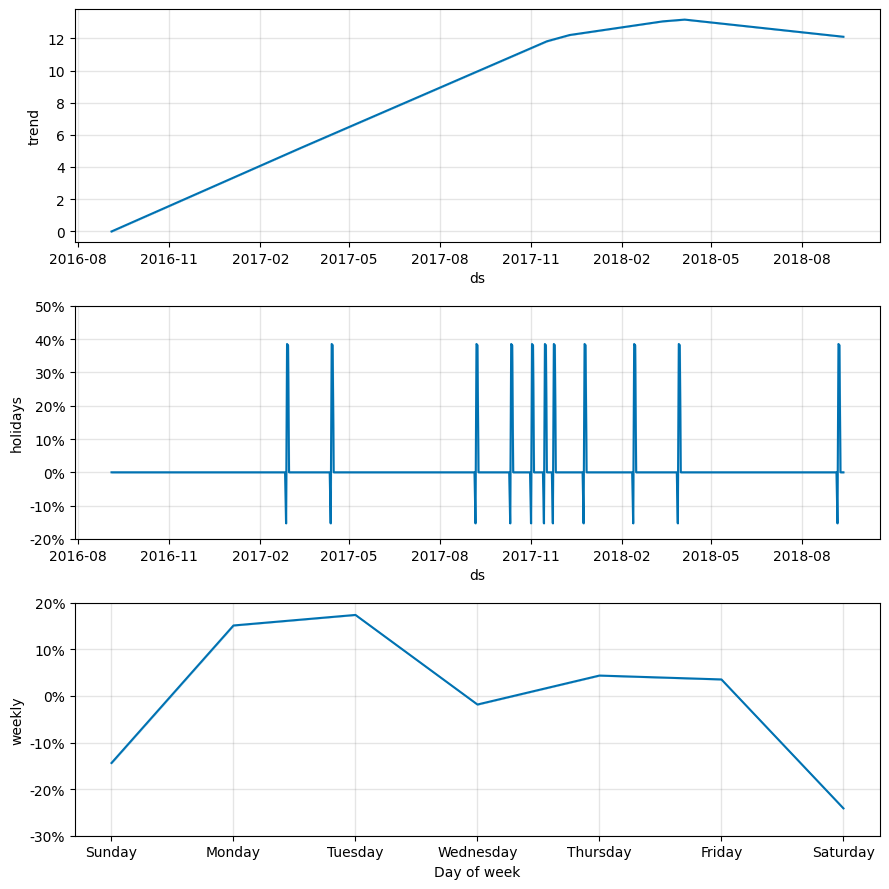

16:01:50 - cmdstanpy - INFO - Chain [1] start processing
16:01:50 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/10 [00:00<?, ?it/s]16:01:50 - cmdstanpy - INFO - Chain [1] start processing
16:01:50 - cmdstanpy - INFO - Chain [1] done processing
16:01:50 - cmdstanpy - INFO - Chain [1] start processing
16:01:50 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 2/10 [00:00<00:00, 10.47it/s]16:01:50 - cmdstanpy - INFO - Chain [1] start processing
16:01:50 - cmdstanpy - INFO - Chain [1] done processing
16:01:50 - cmdstanpy - INFO - Chain [1] start processing
16:01:50 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 4/10 [00:00<00:00,  8.95it/s]16:01:50 - cmdstanpy - INFO - Chain [1] start processing
16:01:51 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 5/10 [00:00<00:00,  7.69it/s]16:01:51 - cmdstanpy - INFO - Chain [1] start processing
16:01:51 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 6/10 [00:00<00:0

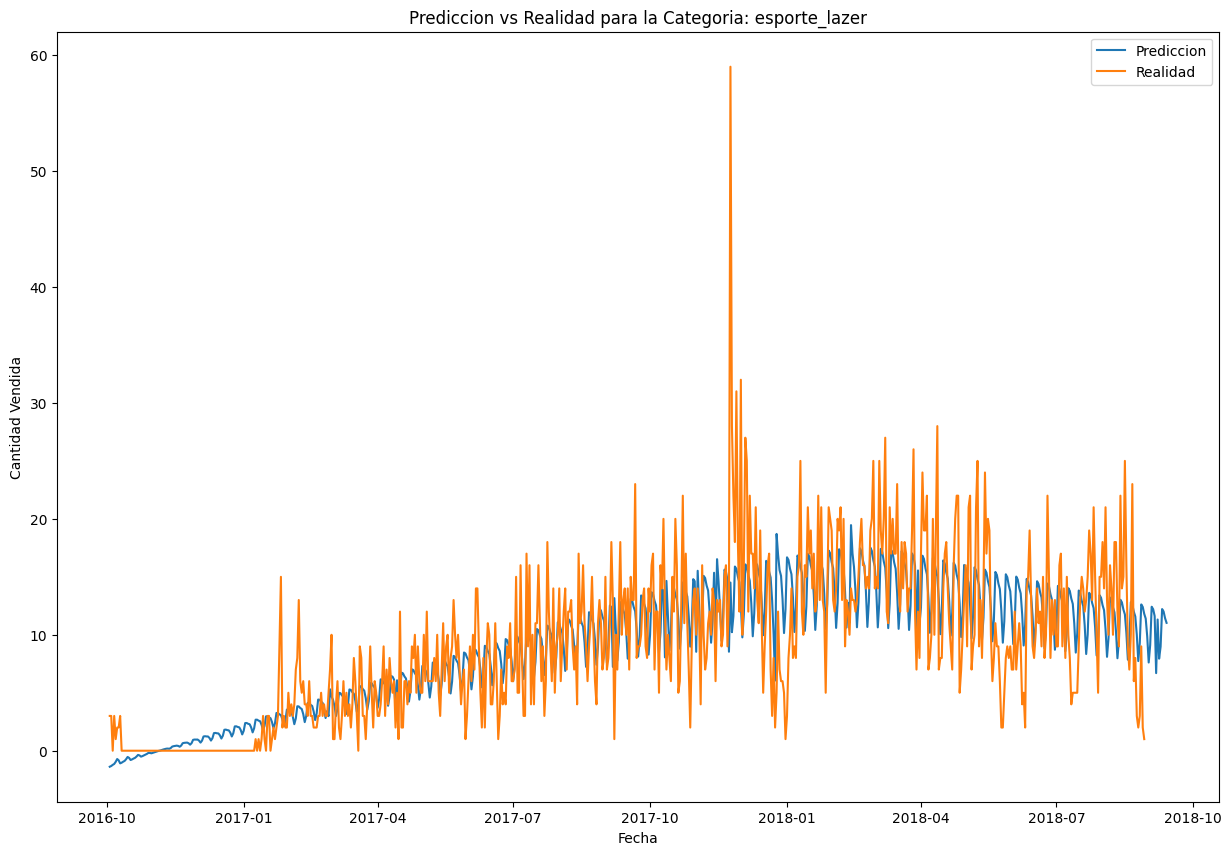

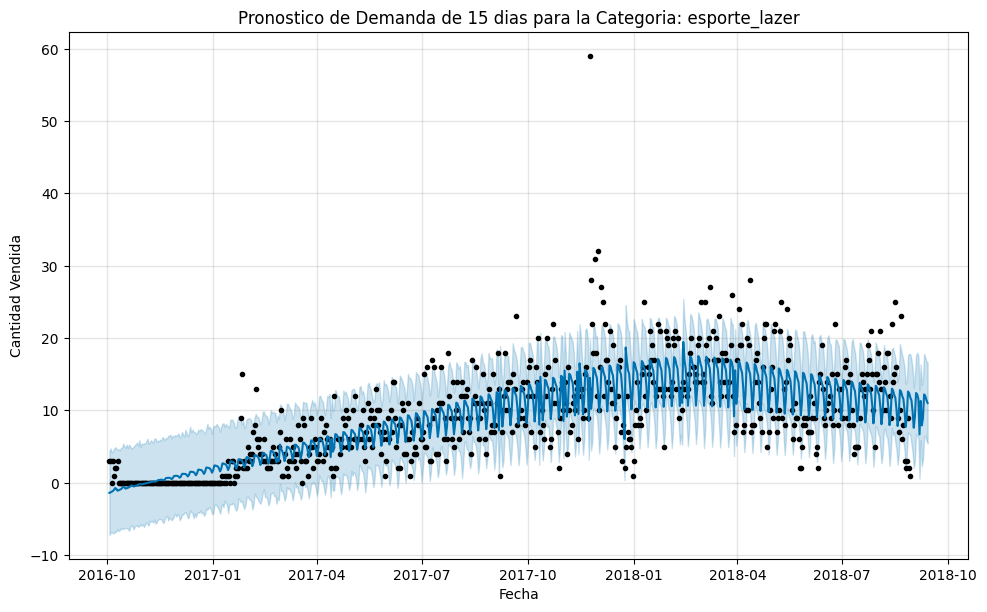

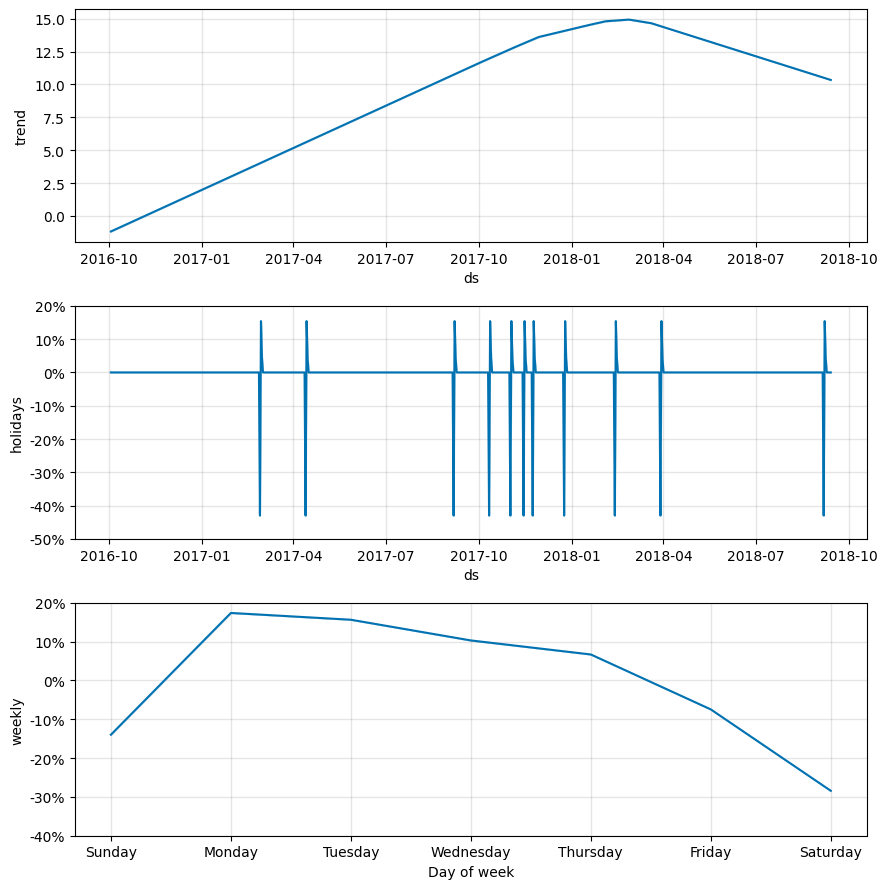

16:01:52 - cmdstanpy - INFO - Chain [1] start processing
16:01:52 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/10 [00:00<?, ?it/s]16:01:52 - cmdstanpy - INFO - Chain [1] start processing
16:01:52 - cmdstanpy - INFO - Chain [1] done processing
16:01:53 - cmdstanpy - INFO - Chain [1] start processing
16:01:53 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 2/10 [00:00<00:00, 10.16it/s]16:01:53 - cmdstanpy - INFO - Chain [1] start processing
16:01:53 - cmdstanpy - INFO - Chain [1] done processing
16:01:53 - cmdstanpy - INFO - Chain [1] start processing
16:01:53 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 4/10 [00:00<00:00,  7.68it/s]16:01:53 - cmdstanpy - INFO - Chain [1] start processing
16:01:53 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 5/10 [00:00<00:00,  8.19it/s]16:01:53 - cmdstanpy - INFO - Chain [1] start processing
16:01:53 - cmdstanpy - INFO - Chain [1] done processing
16:01:53 - cmdstanpy - INFO - Cha

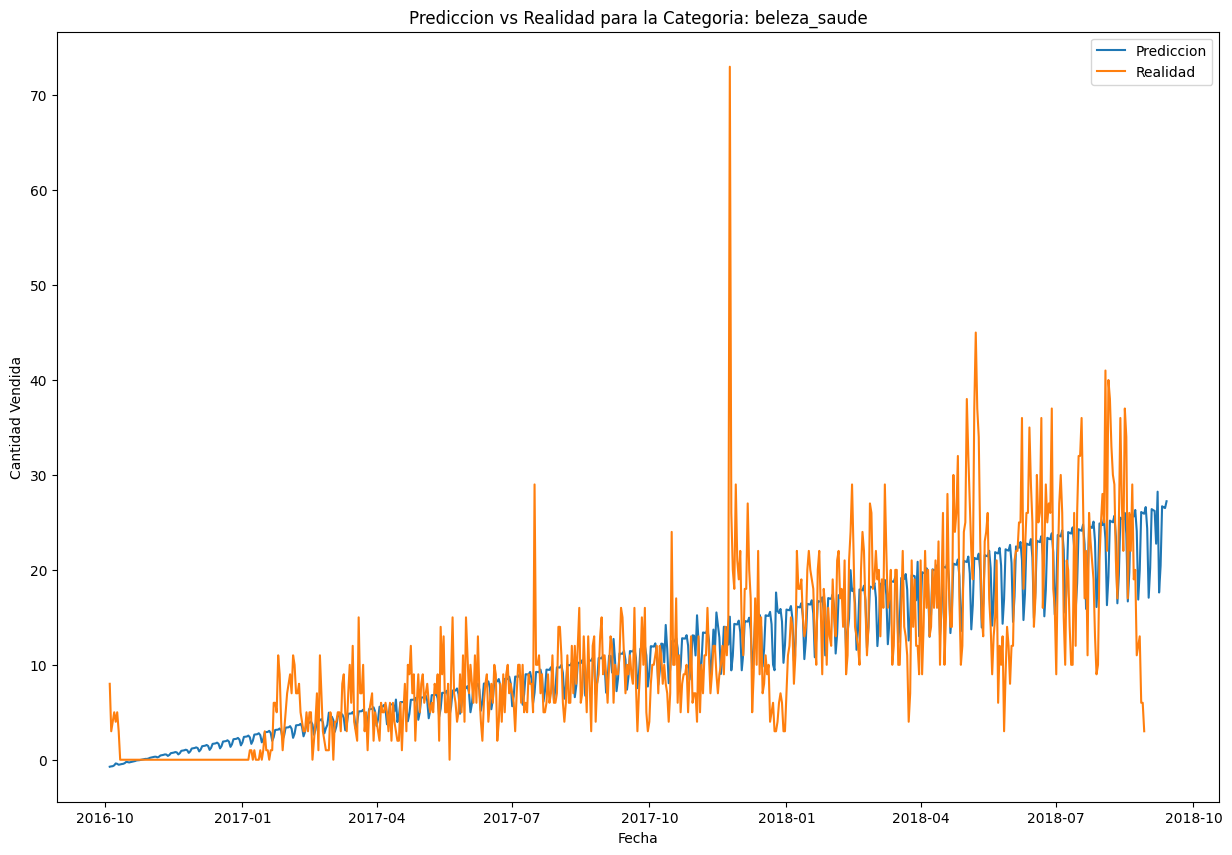

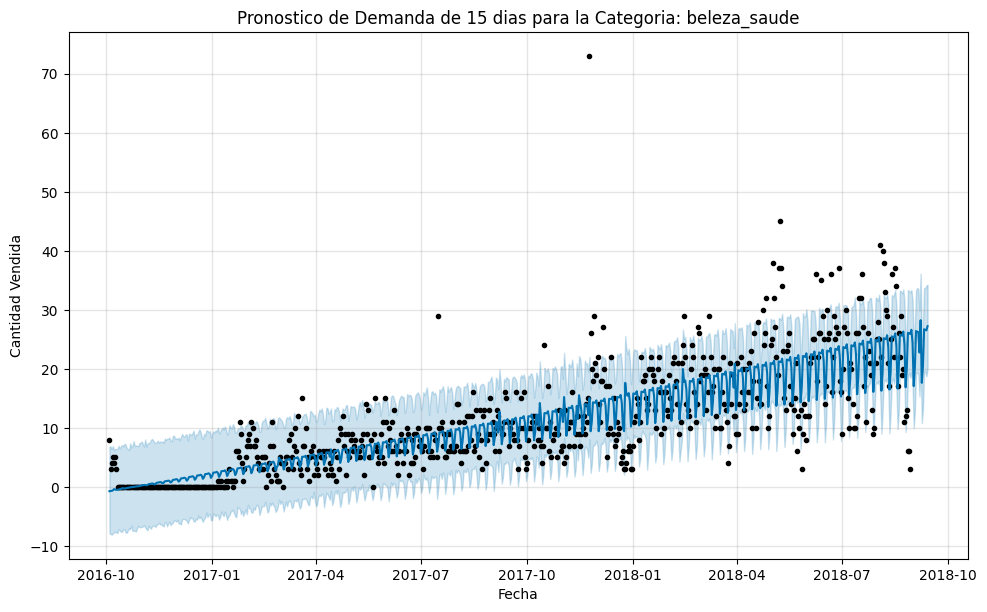

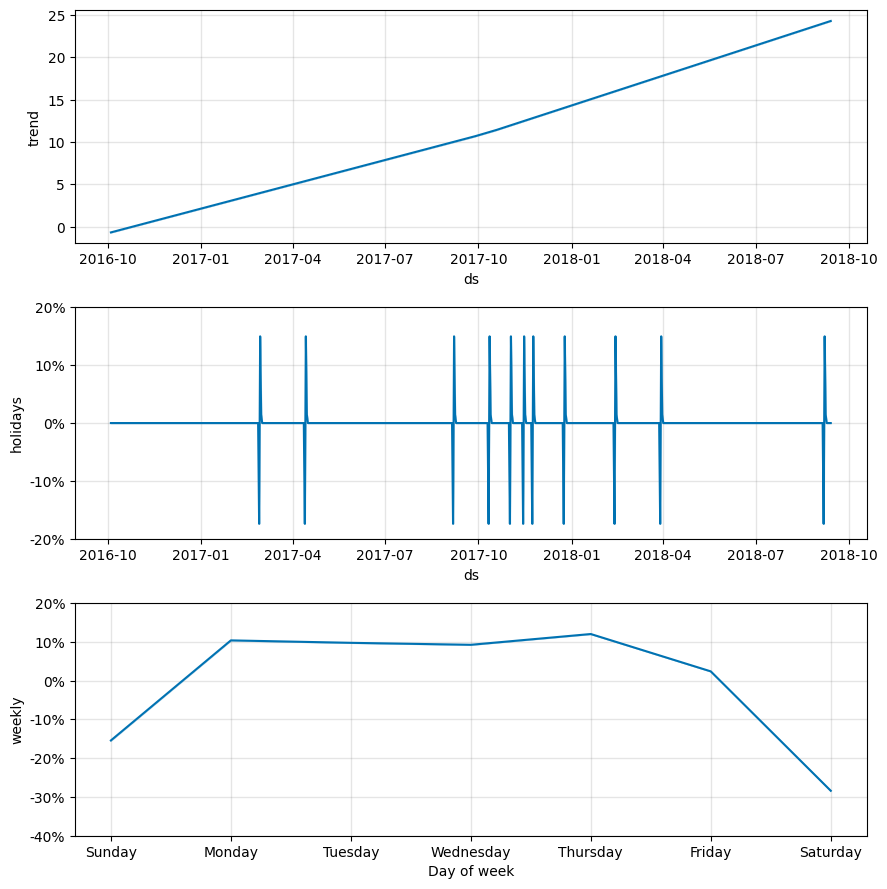

16:01:55 - cmdstanpy - INFO - Chain [1] start processing
16:01:55 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/10 [00:00<?, ?it/s]16:01:55 - cmdstanpy - INFO - Chain [1] start processing
16:01:55 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 1/10 [00:00<00:01,  6.19it/s]16:01:55 - cmdstanpy - INFO - Chain [1] start processing
16:01:55 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 2/10 [00:00<00:01,  6.16it/s]16:01:55 - cmdstanpy - INFO - Chain [1] start processing
16:01:55 - cmdstanpy - INFO - Chain [1] done processing
 30%|███       | 3/10 [00:00<00:00,  7.19it/s]16:01:55 - cmdstanpy - INFO - Chain [1] start processing
16:01:55 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 4/10 [00:00<00:00,  7.34it/s]16:01:55 - cmdstanpy - INFO - Chain [1] start processing
16:01:55 - cmdstanpy - INFO - Chain [1] done processing


 50%|█████     | 5/10 [00:00<00:00,  7.12it/s]16:01:56 - cmdstanpy - INFO - Chain [1] start processing
16:01:56 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 6/10 [00:00<00:00,  5.30it/s]16:01:56 - cmdstanpy - INFO - Chain [1] start processing
16:01:56 - cmdstanpy - INFO - Chain [1] done processing
 70%|███████   | 7/10 [00:01<00:00,  4.62it/s]16:01:56 - cmdstanpy - INFO - Chain [1] start processing
16:01:56 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 8/10 [00:01<00:00,  5.43it/s]16:01:56 - cmdstanpy - INFO - Chain [1] start processing
16:01:56 - cmdstanpy - INFO - Chain [1] done processing
 90%|█████████ | 9/10 [00:01<00:00,  5.29it/s]16:01:56 - cmdstanpy - INFO - Chain [1] start processing
16:01:57 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 10/10 [00:01<00:00,  5.70it/s]


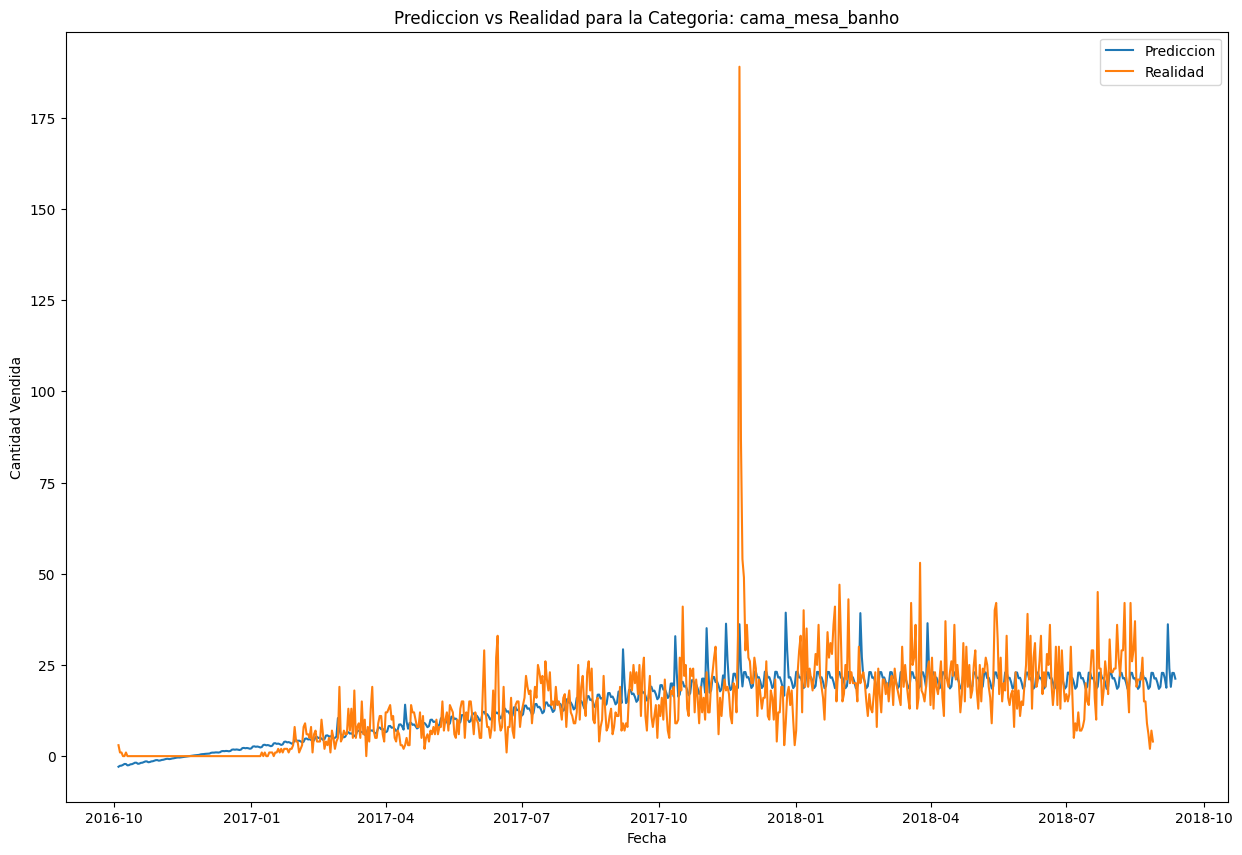

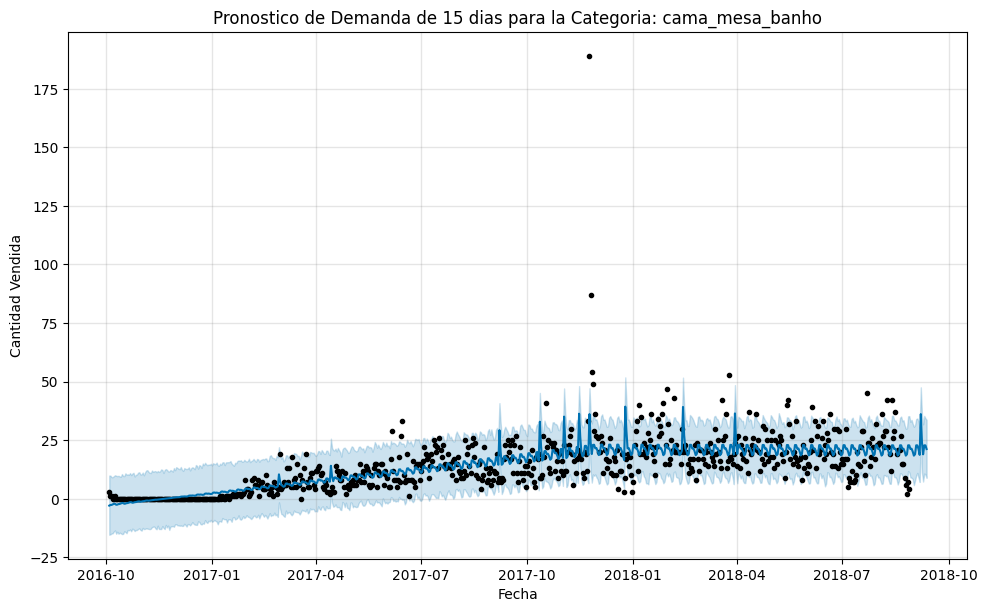

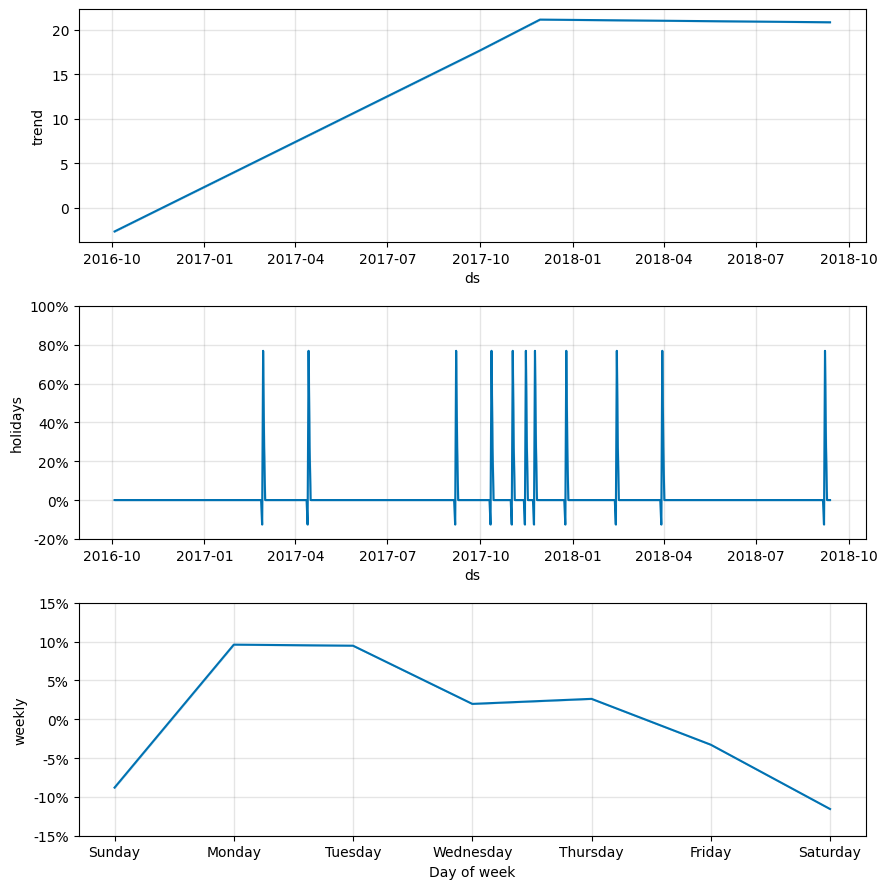

16:01:58 - cmdstanpy - INFO - Chain [1] start processing
16:01:58 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/10 [00:00<?, ?it/s]16:01:58 - cmdstanpy - INFO - Chain [1] start processing
16:01:58 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 1/10 [00:00<00:01,  8.02it/s]16:01:58 - cmdstanpy - INFO - Chain [1] start processing
16:01:58 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 2/10 [00:00<00:01,  5.96it/s]16:01:59 - cmdstanpy - INFO - Chain [1] start processing
16:01:59 - cmdstanpy - INFO - Chain [1] done processing
 30%|███       | 3/10 [00:00<00:01,  6.64it/s]16:01:59 - cmdstanpy - INFO - Chain [1] start processing
16:01:59 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 4/10 [00:00<00:00,  7.40it/s]16:01:59 - cmdstanpy - INFO - Chain [1] start processing
16:01:59 - cmdstanpy - INFO - Chain [1] done processing
16:01:59 - cmdstanpy - INFO - Chain [1] start processing
16:01:59 - cmdstanpy - INFO - Chain [1] don

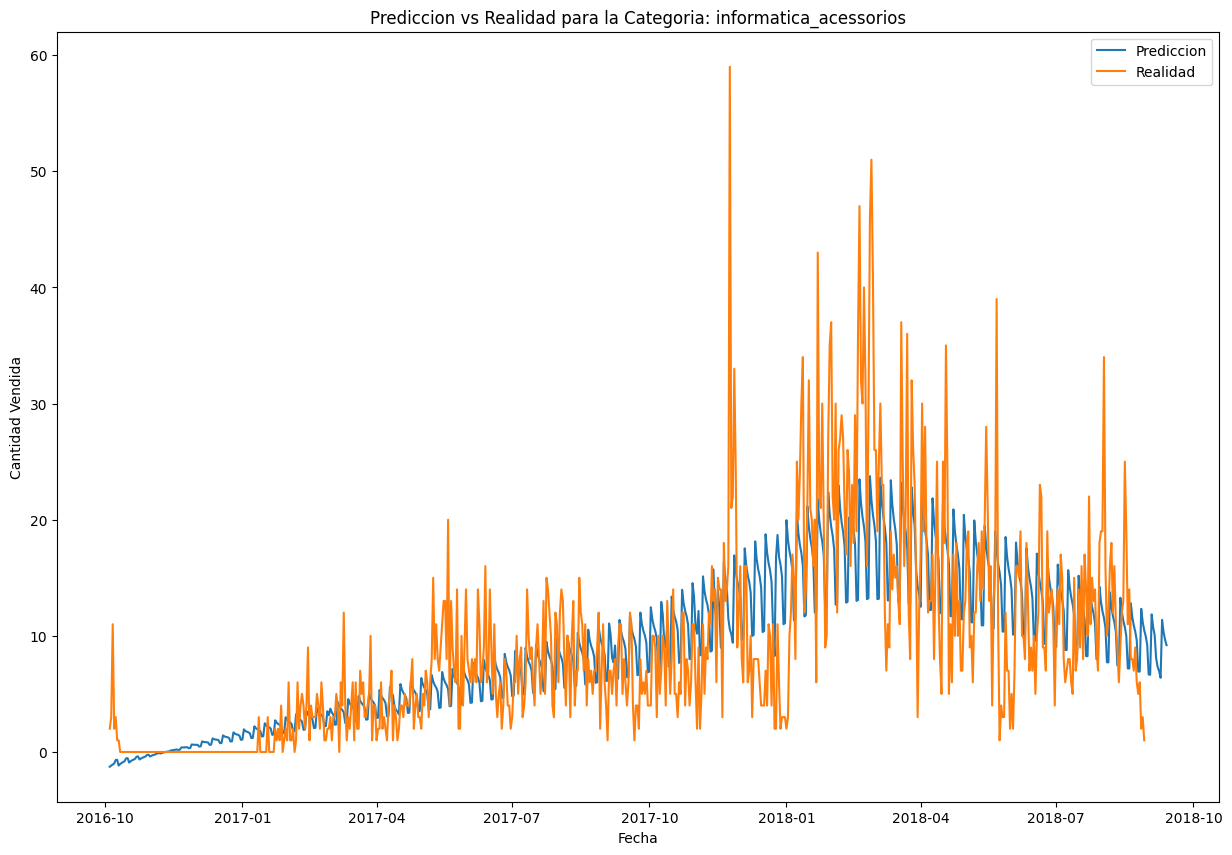

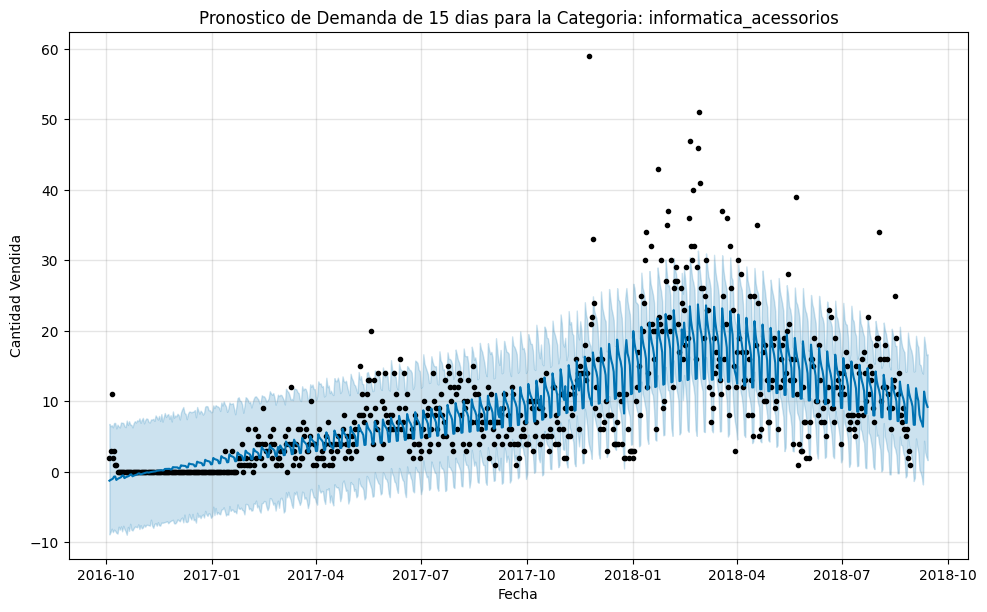

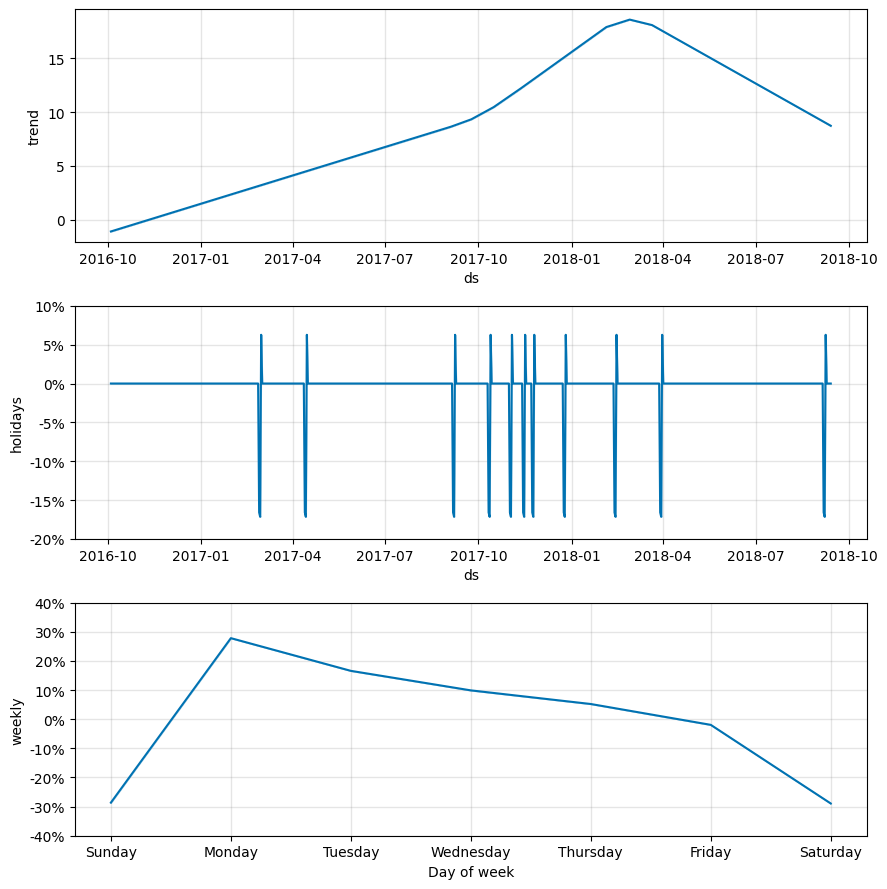

16:02:01 - cmdstanpy - INFO - Chain [1] start processing
16:02:01 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/12 [00:00<?, ?it/s]16:02:01 - cmdstanpy - INFO - Chain [1] start processing
16:02:01 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:01,  7.75it/s]16:02:01 - cmdstanpy - INFO - Chain [1] start processing
16:02:01 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 2/12 [00:00<00:01,  8.91it/s]16:02:01 - cmdstanpy - INFO - Chain [1] start processing
16:02:01 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 3/12 [00:00<00:01,  8.56it/s]16:02:01 - cmdstanpy - INFO - Chain [1] start processing
16:02:01 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 4/12 [00:00<00:00,  9.01it/s]16:02:01 - cmdstanpy - INFO - Chain [1] start processing
16:02:02 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 5/12 [00:00<00:01,  6.69it/s]16:02:02 - cmdstanpy - INFO - Chain [1] start processi

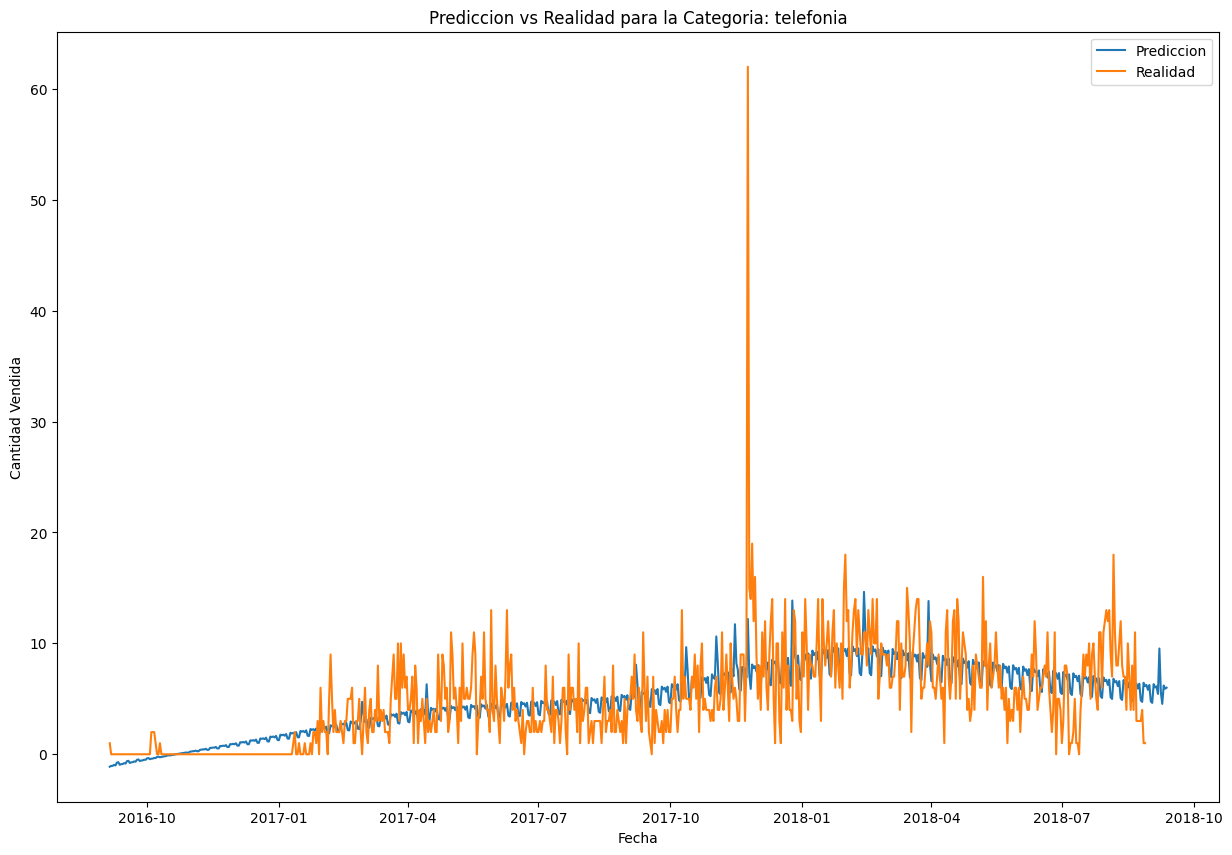

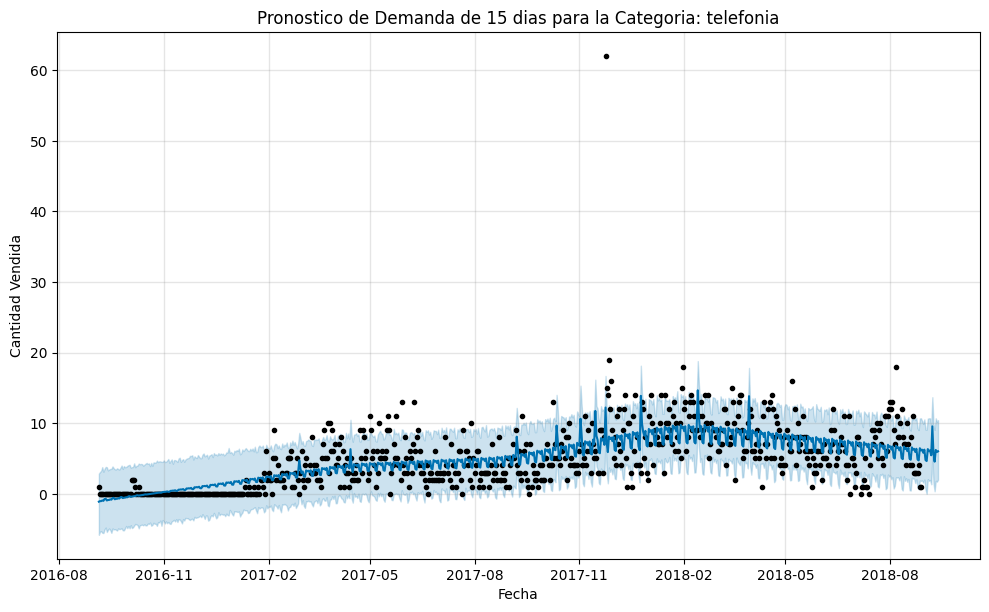

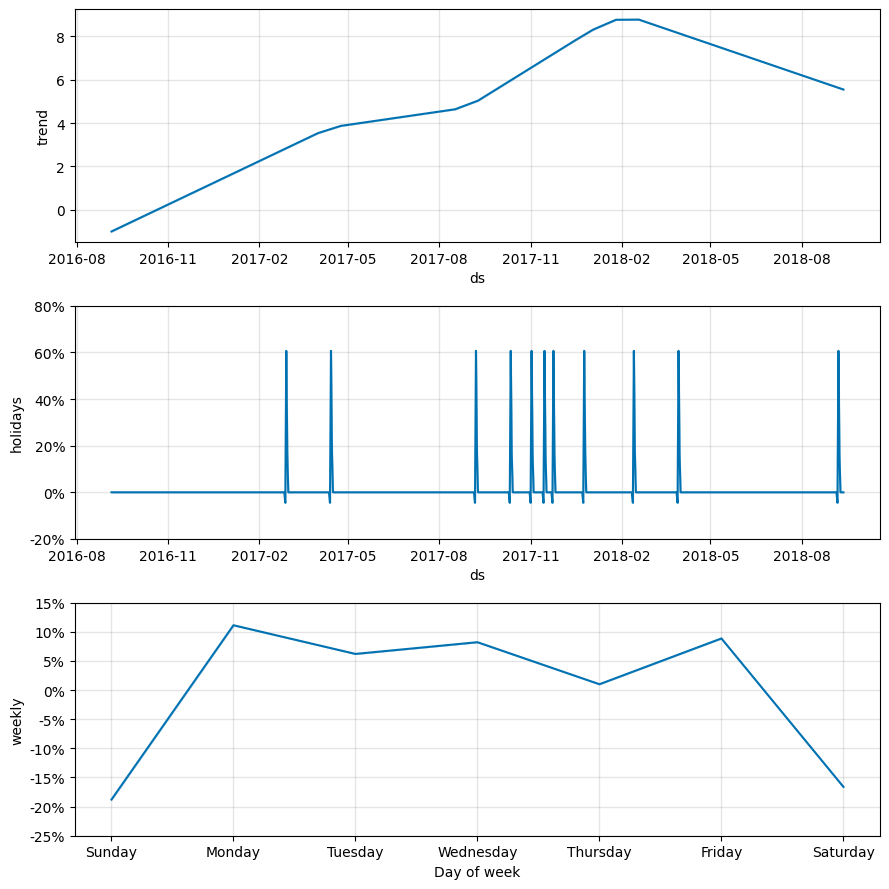

16:02:04 - cmdstanpy - INFO - Chain [1] start processing
16:02:04 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/10 [00:00<?, ?it/s]16:02:04 - cmdstanpy - INFO - Chain [1] start processing
16:02:04 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 1/10 [00:00<00:01,  4.66it/s]16:02:04 - cmdstanpy - INFO - Chain [1] start processing
16:02:04 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 2/10 [00:00<00:01,  5.98it/s]16:02:04 - cmdstanpy - INFO - Chain [1] start processing
16:02:04 - cmdstanpy - INFO - Chain [1] done processing
16:02:04 - cmdstanpy - INFO - Chain [1] start processing
16:02:05 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 4/10 [00:00<00:00,  6.72it/s]16:02:05 - cmdstanpy - INFO - Chain [1] start processing
16:02:05 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 5/10 [00:00<00:00,  6.37it/s]16:02:05 - cmdstanpy - INFO - Chain [1] start processing
16:02:05 - cmdstanpy - INFO - Chain [1] don

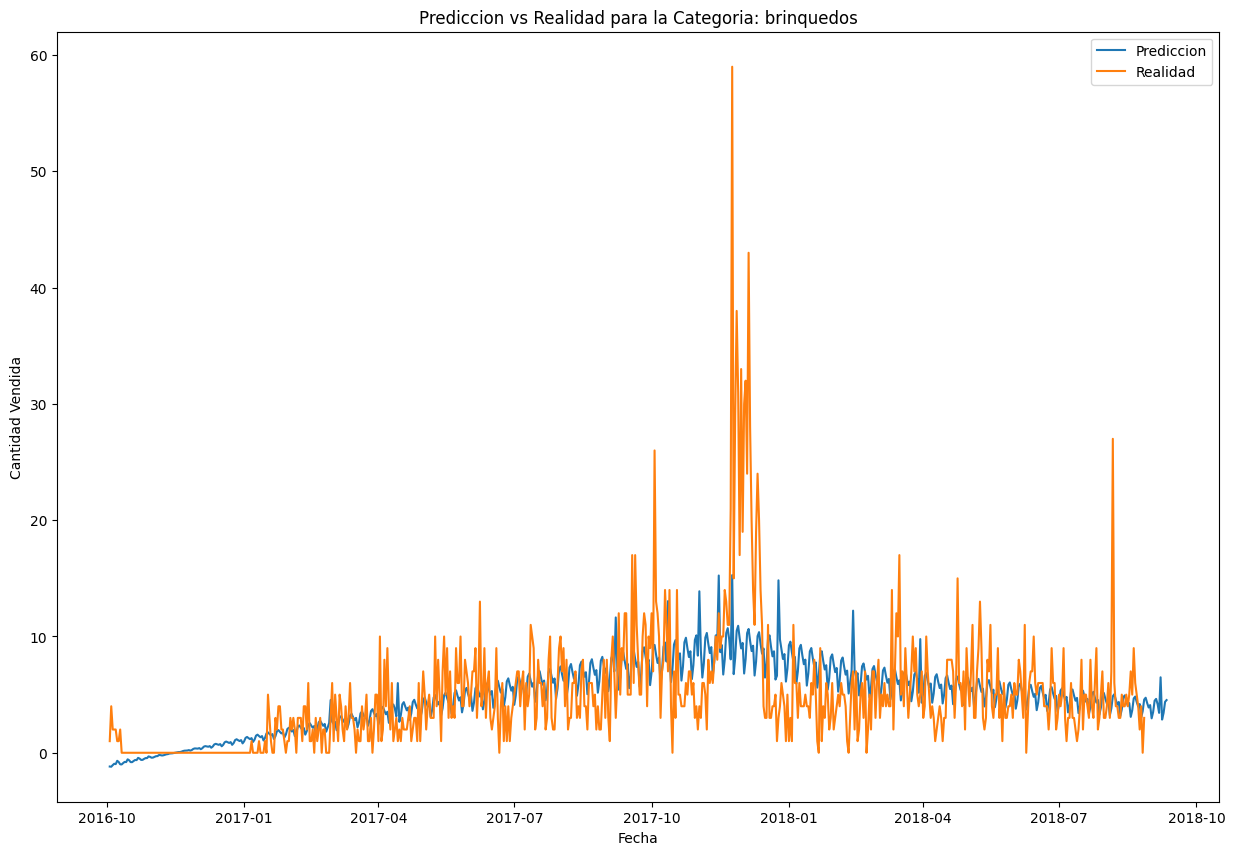

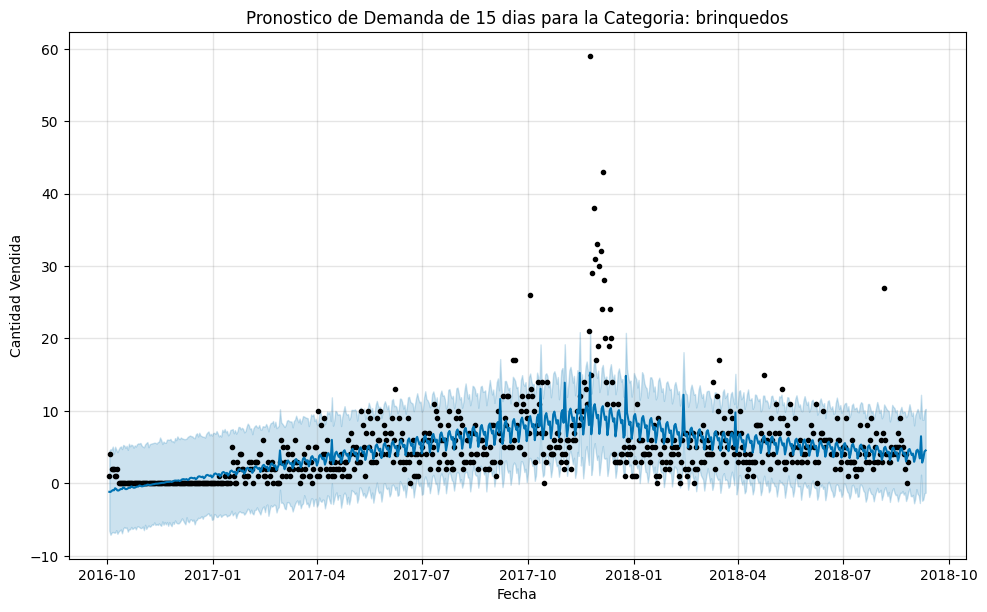

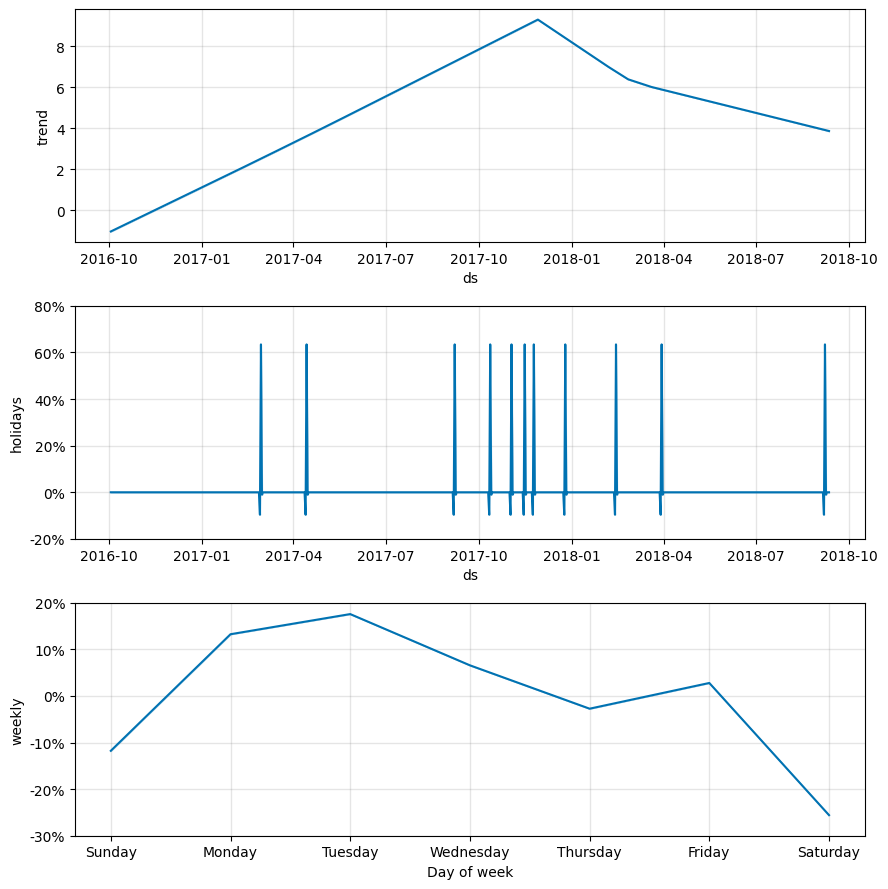

16:02:06 - cmdstanpy - INFO - Chain [1] start processing
16:02:06 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/10 [00:00<?, ?it/s]16:02:07 - cmdstanpy - INFO - Chain [1] start processing
16:02:07 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 1/10 [00:00<00:02,  3.07it/s]16:02:07 - cmdstanpy - INFO - Chain [1] start processing
16:02:07 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 2/10 [00:00<00:01,  4.80it/s]16:02:07 - cmdstanpy - INFO - Chain [1] start processing
16:02:07 - cmdstanpy - INFO - Chain [1] done processing
16:02:07 - cmdstanpy - INFO - Chain [1] start processing
16:02:07 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 4/10 [00:00<00:00,  7.21it/s]16:02:07 - cmdstanpy - INFO - Chain [1] start processing
16:02:07 - cmdstanpy - INFO - Chain [1] done processing
16:02:07 - cmdstanpy - INFO - Chain [1] start processing
16:02:07 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 6/10 [00:00<00:0

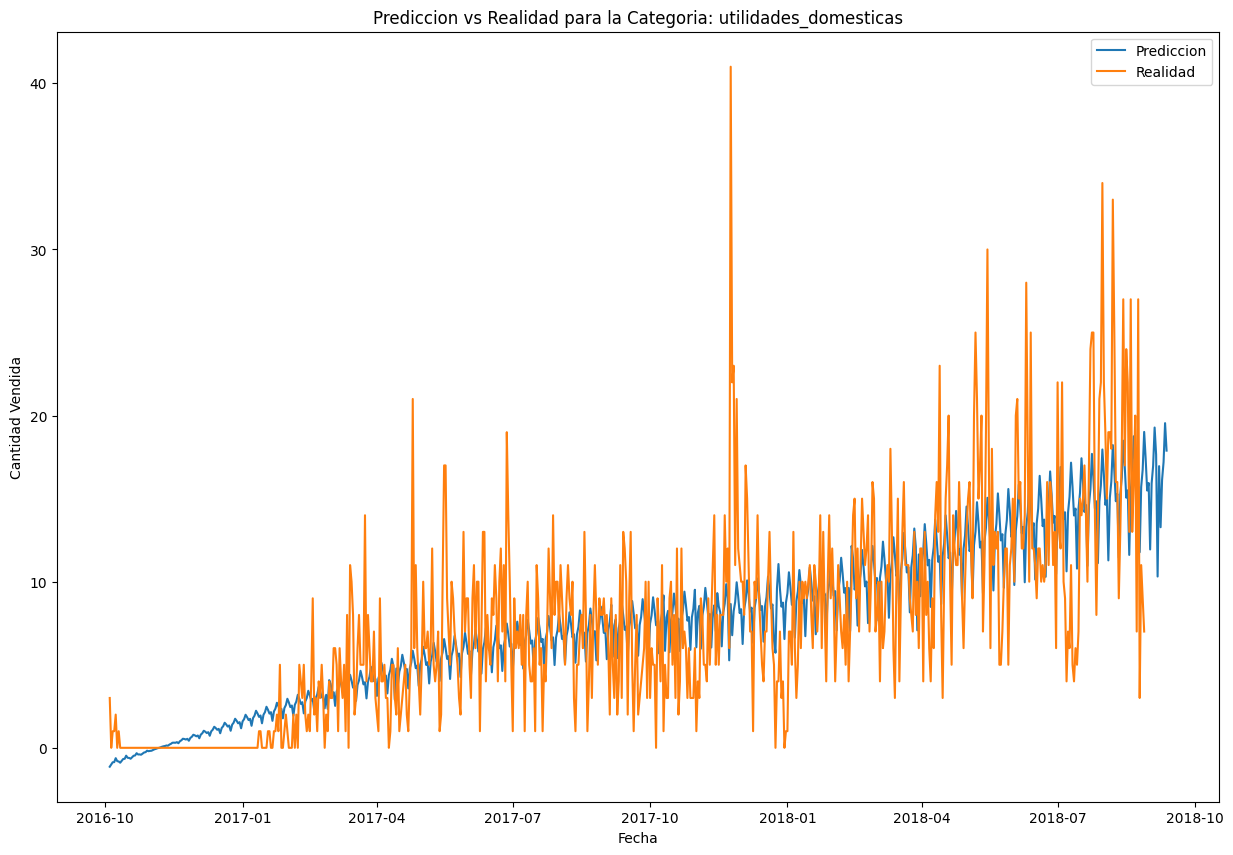

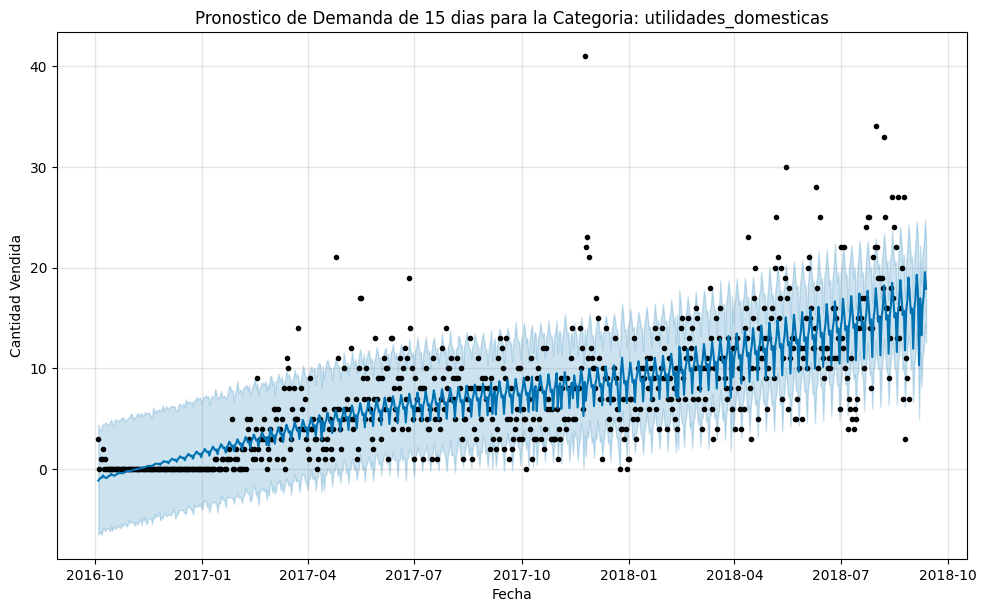

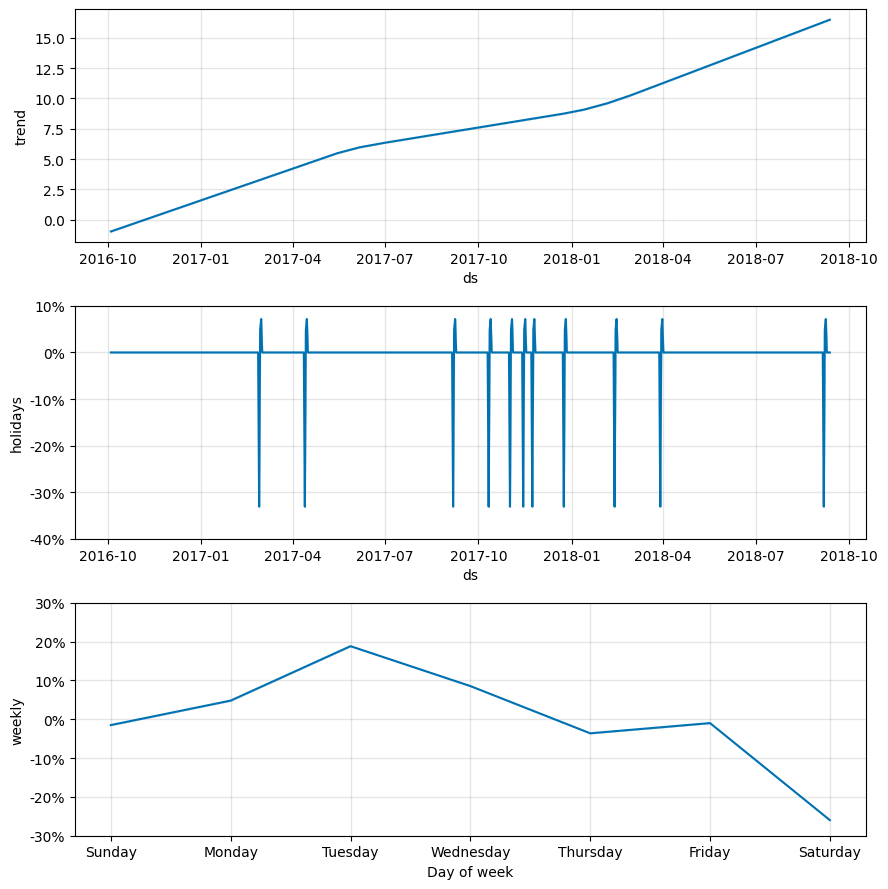

16:02:09 - cmdstanpy - INFO - Chain [1] start processing
16:02:09 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/10 [00:00<?, ?it/s]16:02:09 - cmdstanpy - INFO - Chain [1] start processing
16:02:09 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 1/10 [00:00<00:02,  4.03it/s]16:02:10 - cmdstanpy - INFO - Chain [1] start processing
16:02:10 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 2/10 [00:00<00:01,  4.76it/s]16:02:10 - cmdstanpy - INFO - Chain [1] start processing
16:02:10 - cmdstanpy - INFO - Chain [1] done processing
 30%|███       | 3/10 [00:00<00:01,  5.22it/s]16:02:10 - cmdstanpy - INFO - Chain [1] start processing
16:02:10 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 4/10 [00:00<00:01,  5.63it/s]16:02:10 - cmdstanpy - INFO - Chain [1] start processing
16:02:10 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 5/10 [00:00<00:00,  6.02it/s]16:02:10 - cmdstanpy - INFO - Chain [1] start processi

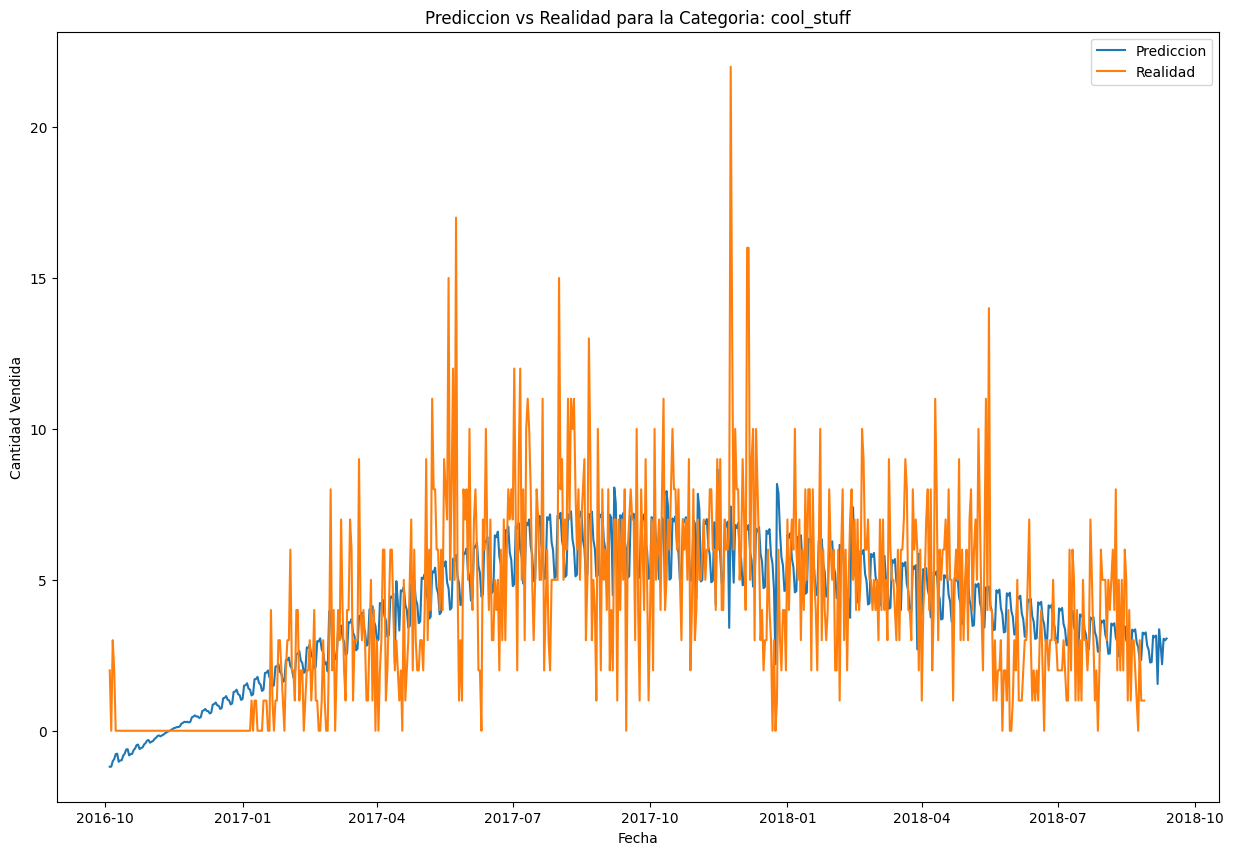

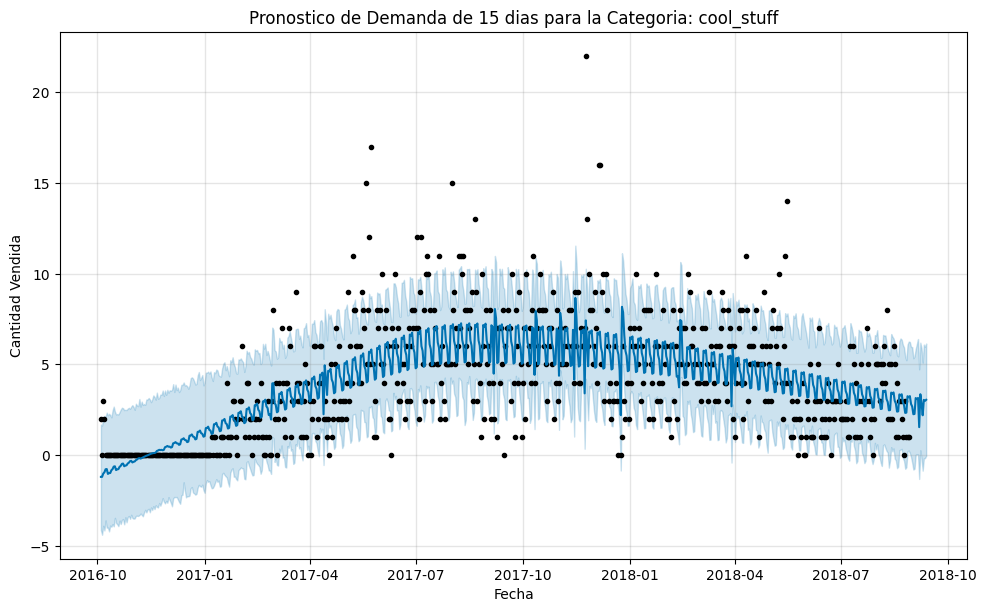

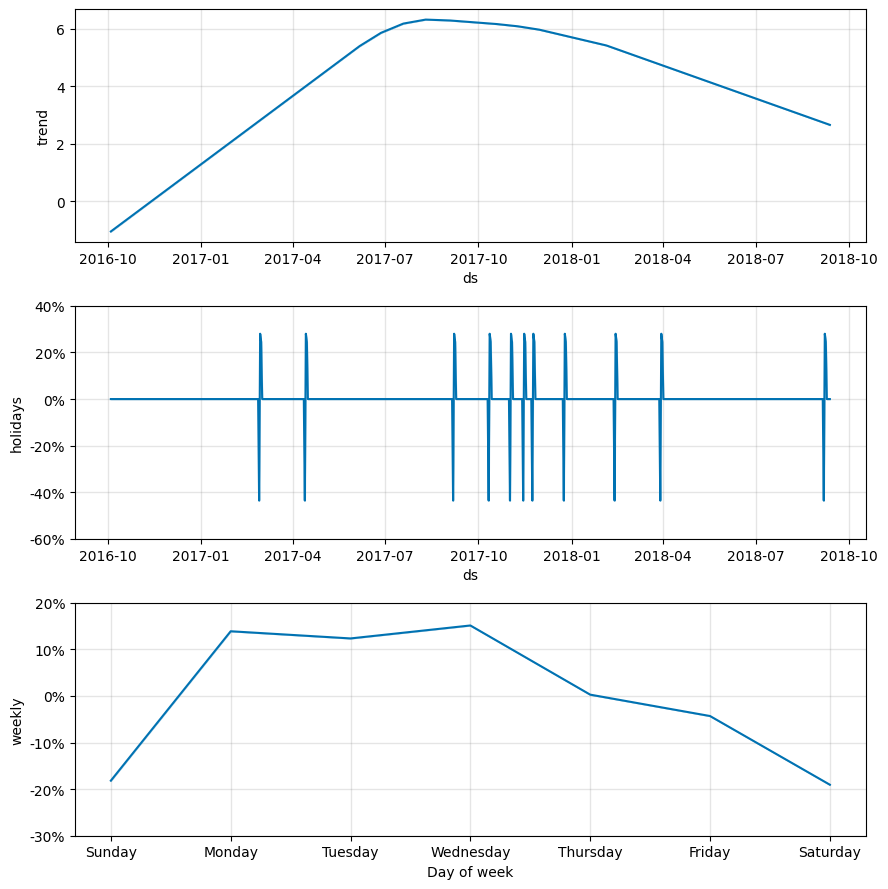

16:02:12 - cmdstanpy - INFO - Chain [1] start processing
16:02:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/10 [00:00<?, ?it/s]16:02:12 - cmdstanpy - INFO - Chain [1] start processing
16:02:13 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 1/10 [00:00<00:01,  6.64it/s]16:02:13 - cmdstanpy - INFO - Chain [1] start processing
16:02:13 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 2/10 [00:00<00:01,  6.36it/s]16:02:13 - cmdstanpy - INFO - Chain [1] start processing
16:02:13 - cmdstanpy - INFO - Chain [1] done processing
 30%|███       | 3/10 [00:00<00:01,  6.66it/s]16:02:13 - cmdstanpy - INFO - Chain [1] start processing
16:02:13 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 4/10 [00:00<00:00,  6.39it/s]16:02:13 - cmdstanpy - INFO - Chain [1] start processing
16:02:13 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 5/10 [00:01<00:01,  4.06it/s]16:02:14 - cmdstanpy - INFO - Chain [1] start processi

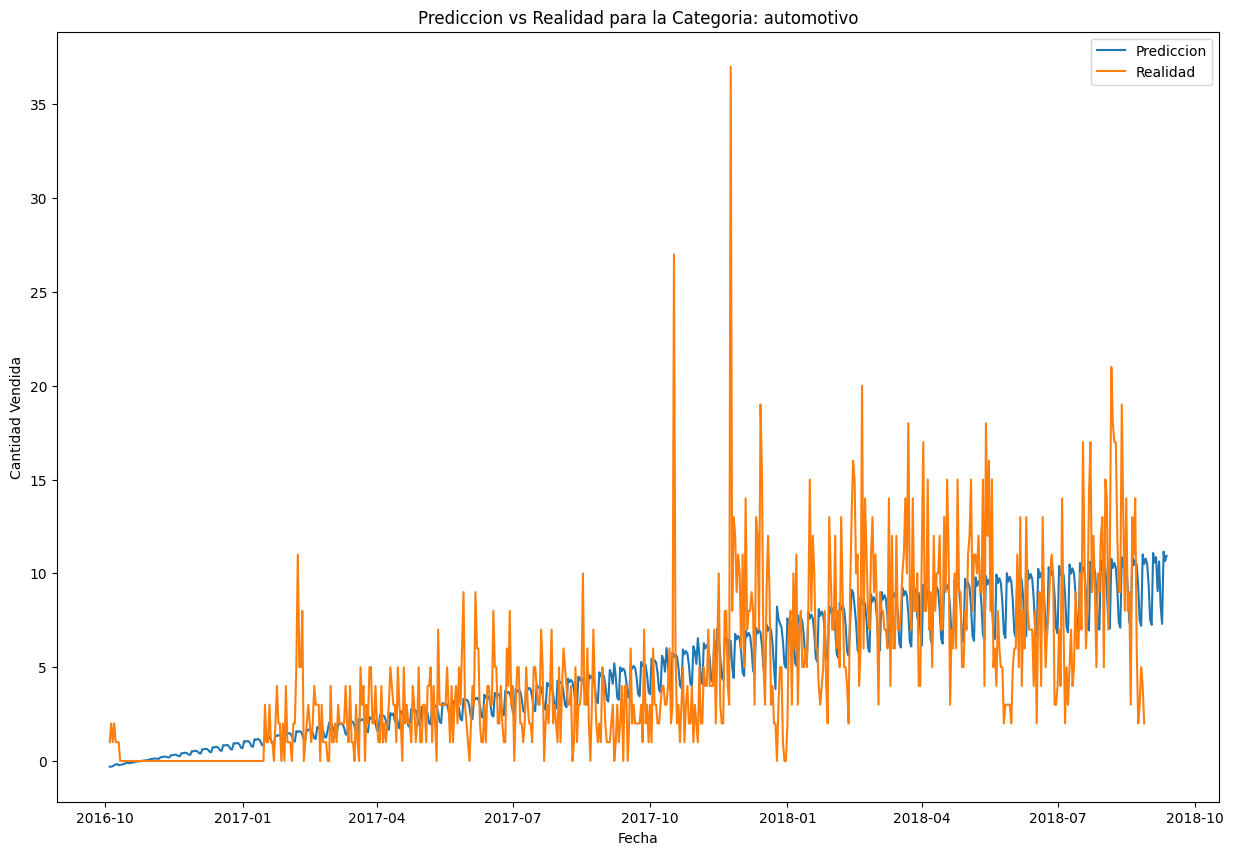

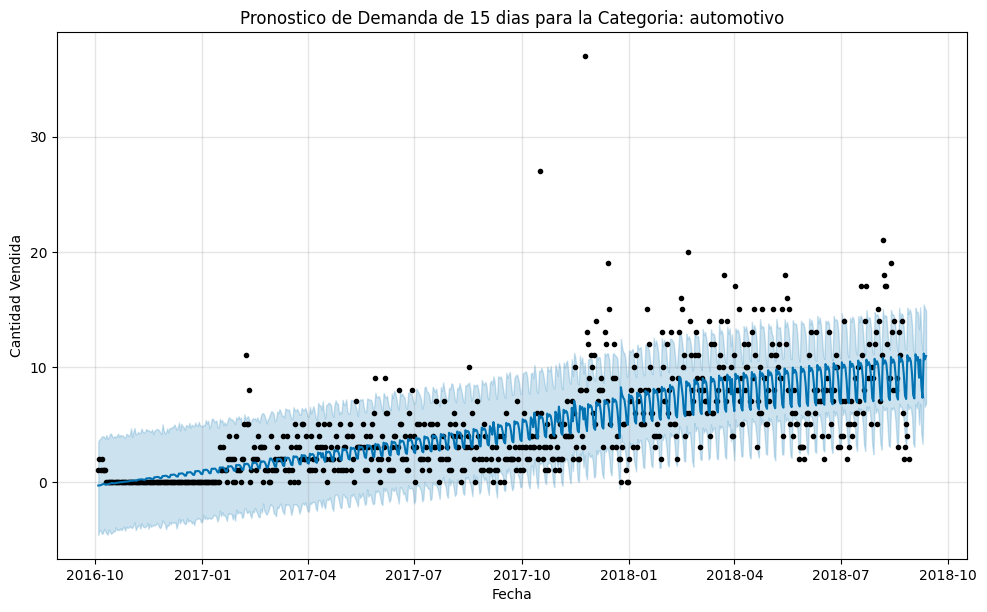

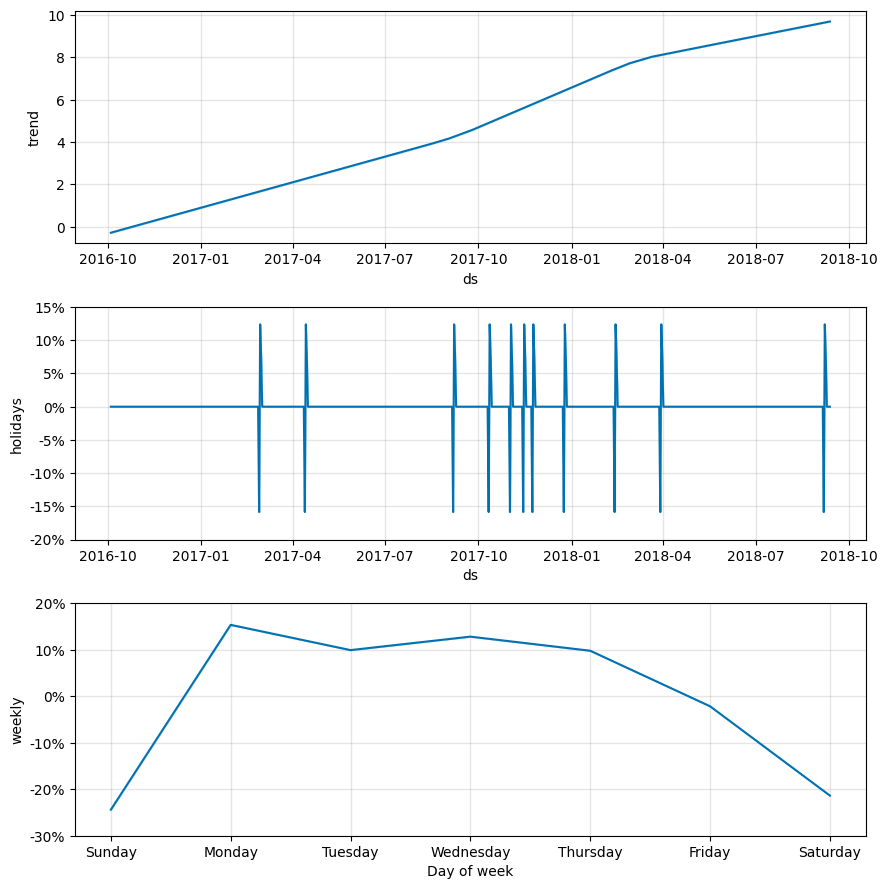

16:02:15 - cmdstanpy - INFO - Chain [1] start processing
16:02:15 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/10 [00:00<?, ?it/s]16:02:15 - cmdstanpy - INFO - Chain [1] start processing
16:02:15 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 1/10 [00:00<00:01,  6.33it/s]16:02:15 - cmdstanpy - INFO - Chain [1] start processing
16:02:16 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 2/10 [00:00<00:01,  6.04it/s]16:02:16 - cmdstanpy - INFO - Chain [1] start processing
16:02:16 - cmdstanpy - INFO - Chain [1] done processing
 30%|███       | 3/10 [00:00<00:01,  6.71it/s]16:02:16 - cmdstanpy - INFO - Chain [1] start processing
16:02:16 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 4/10 [00:00<00:00,  6.83it/s]16:02:16 - cmdstanpy - INFO - Chain [1] start processing
16:02:16 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 5/10 [00:00<00:00,  6.22it/s]16:02:16 - cmdstanpy - INFO - Chain [1] start processi

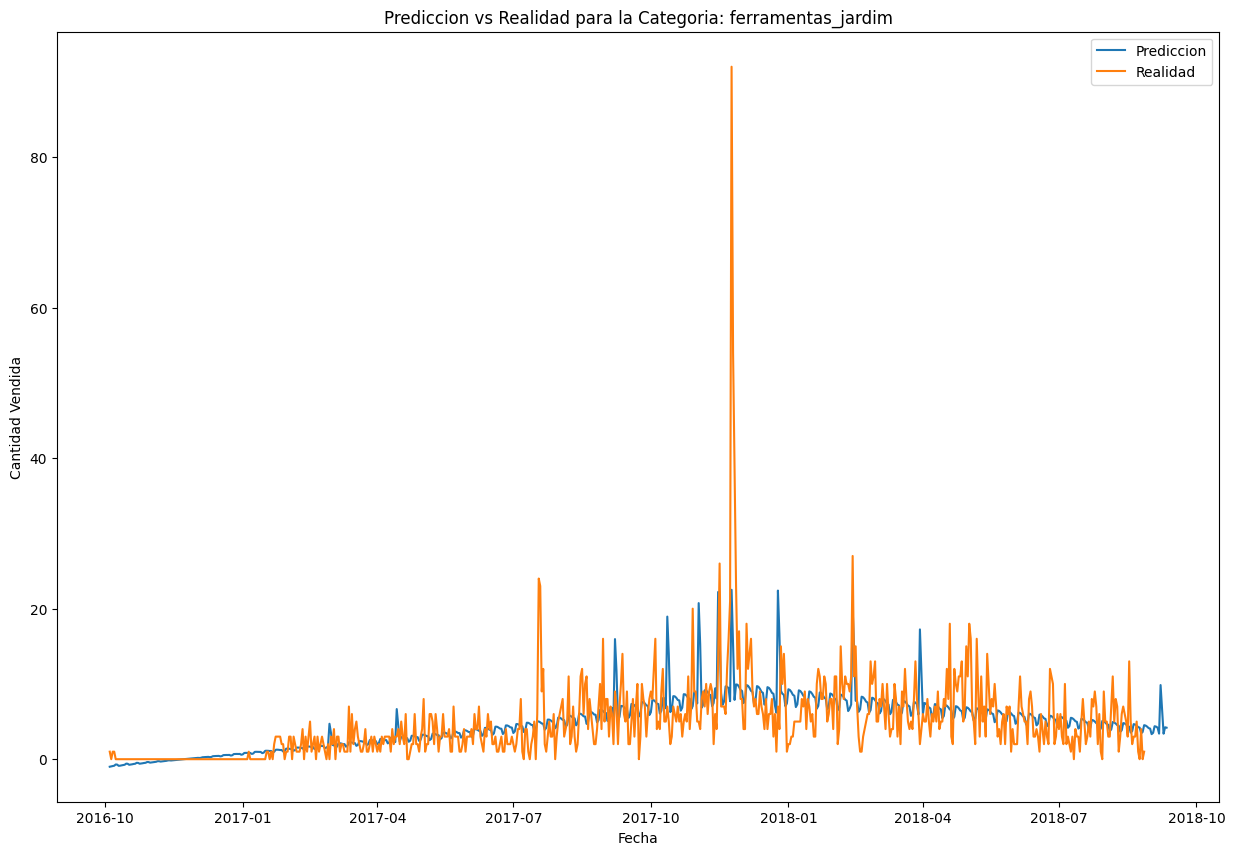

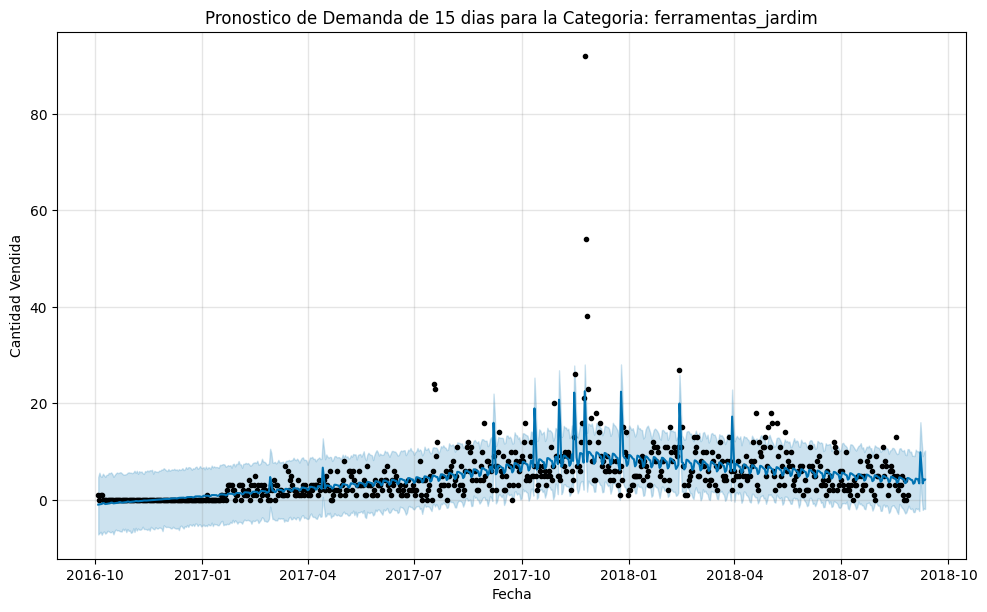

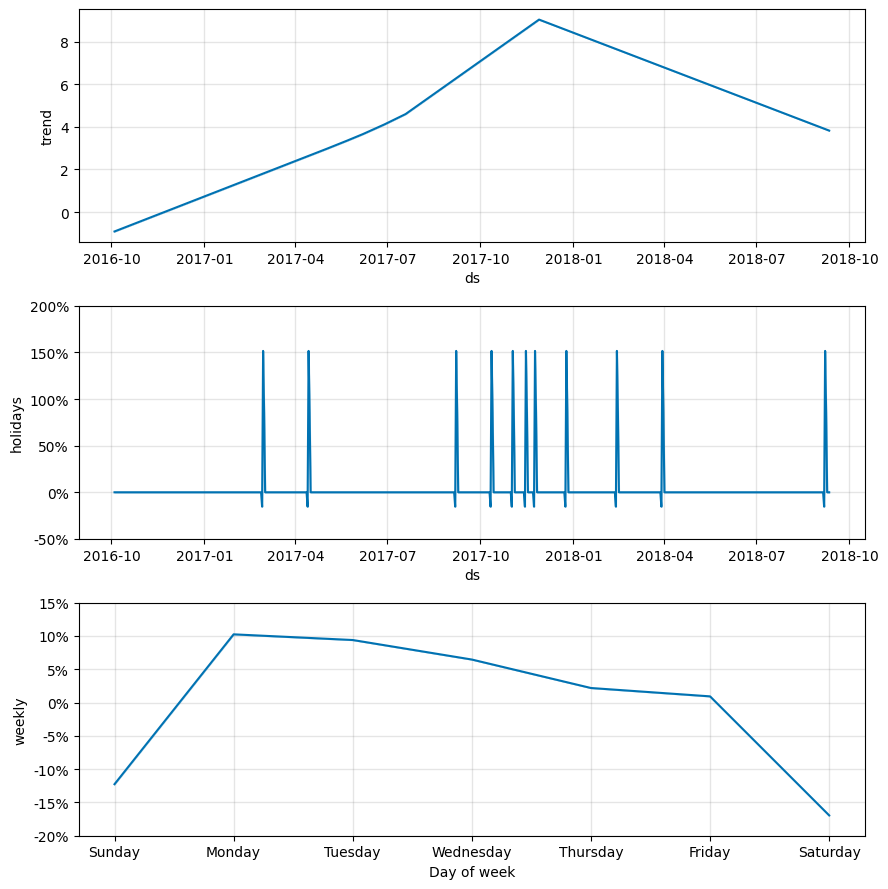

16:02:18 - cmdstanpy - INFO - Chain [1] start processing
16:02:18 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/10 [00:00<?, ?it/s]16:02:18 - cmdstanpy - INFO - Chain [1] start processing
16:02:18 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 1/10 [00:00<00:01,  6.06it/s]16:02:18 - cmdstanpy - INFO - Chain [1] start processing
16:02:18 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 2/10 [00:00<00:01,  6.25it/s]16:02:18 - cmdstanpy - INFO - Chain [1] start processing
16:02:18 - cmdstanpy - INFO - Chain [1] done processing
 30%|███       | 3/10 [00:00<00:01,  6.84it/s]16:02:18 - cmdstanpy - INFO - Chain [1] start processing
16:02:18 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 4/10 [00:00<00:00,  6.54it/s]16:02:19 - cmdstanpy - INFO - Chain [1] start processing
16:02:19 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 5/10 [00:00<00:00,  6.04it/s]16:02:19 - cmdstanpy - INFO - Chain [1] start processi

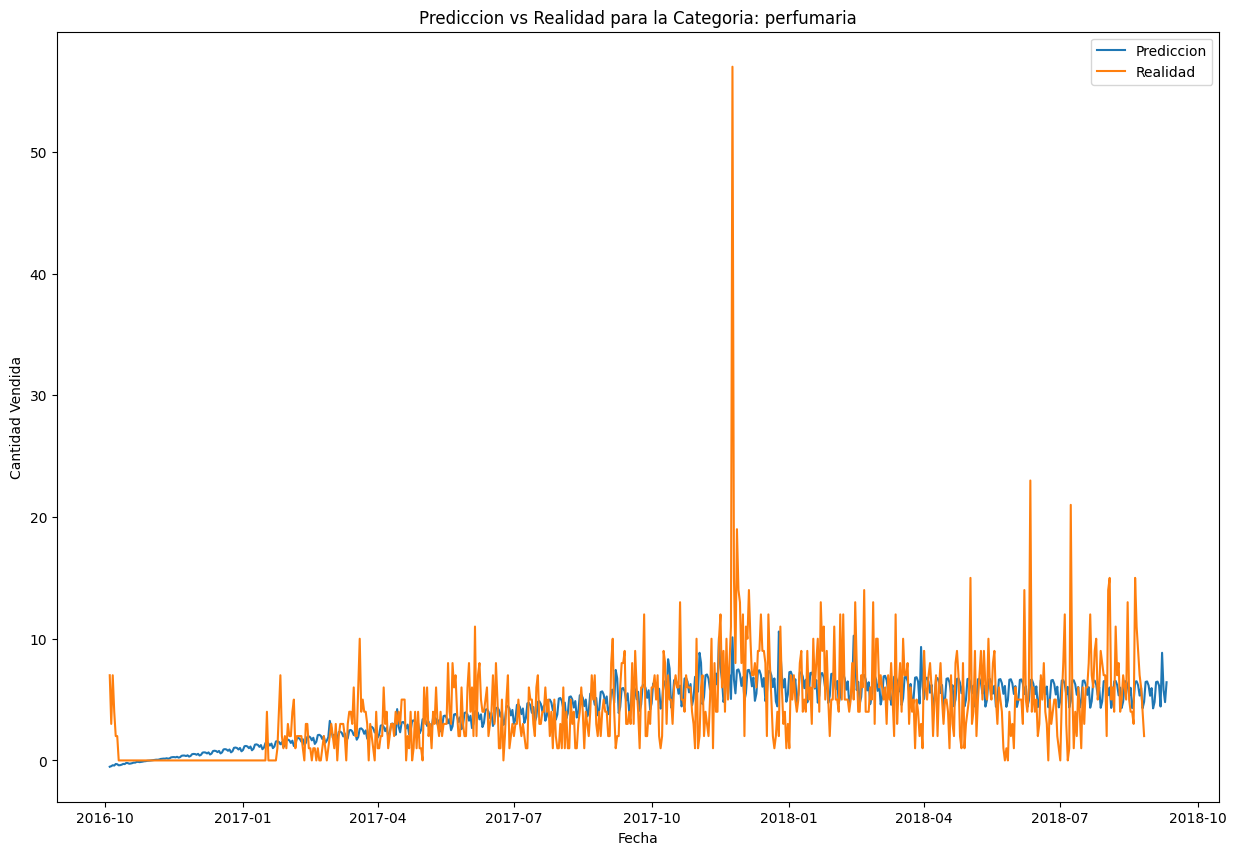

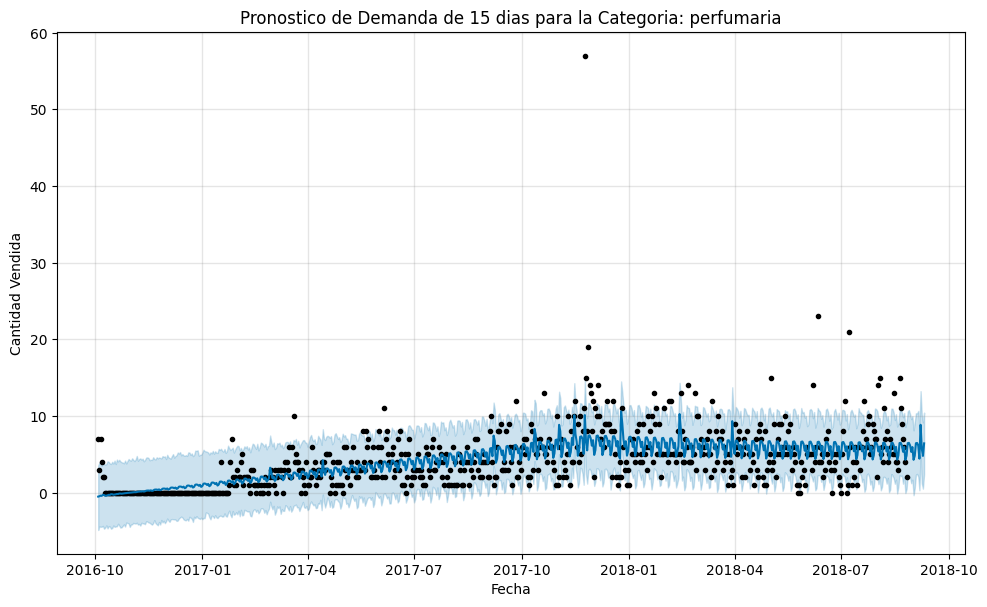

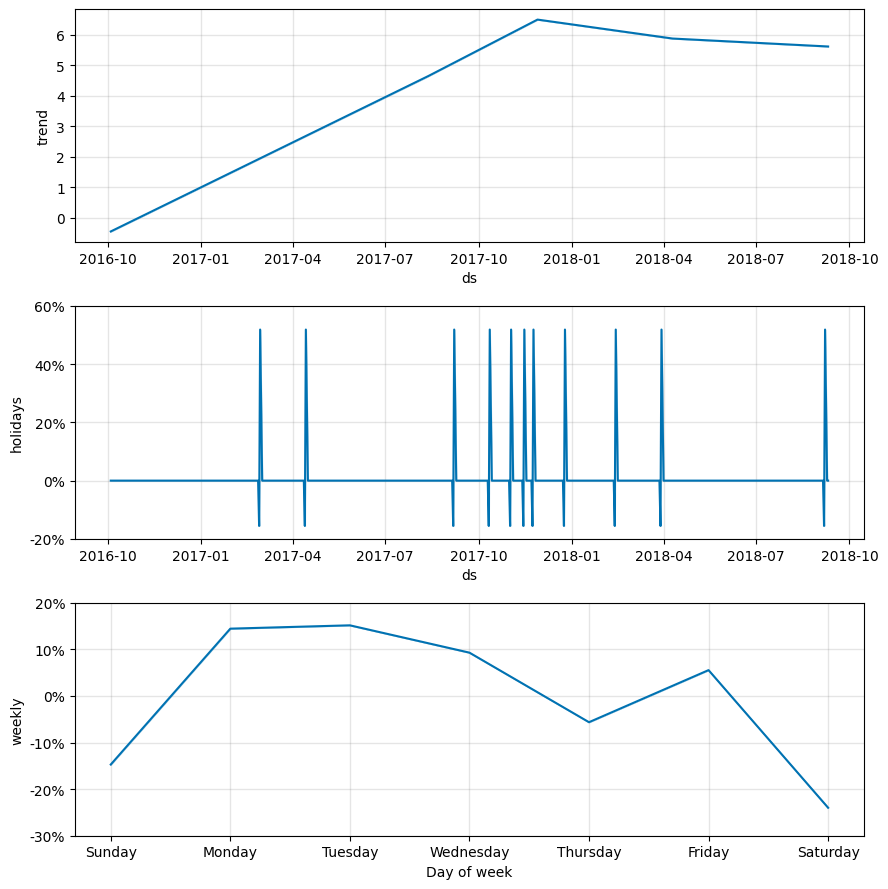

16:02:21 - cmdstanpy - INFO - Chain [1] start processing
16:02:21 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/10 [00:00<?, ?it/s]16:02:21 - cmdstanpy - INFO - Chain [1] start processing
16:02:21 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 1/10 [00:00<00:01,  6.29it/s]16:02:21 - cmdstanpy - INFO - Chain [1] start processing
16:02:21 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 2/10 [00:00<00:01,  7.11it/s]16:02:21 - cmdstanpy - INFO - Chain [1] start processing
16:02:21 - cmdstanpy - INFO - Chain [1] done processing
 30%|███       | 3/10 [00:00<00:01,  6.78it/s]16:02:21 - cmdstanpy - INFO - Chain [1] start processing
16:02:21 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 4/10 [00:00<00:00,  6.51it/s]16:02:22 - cmdstanpy - INFO - Chain [1] start processing
16:02:22 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 5/10 [00:00<00:00,  5.54it/s]16:02:22 - cmdstanpy - INFO - Chain [1] start processi

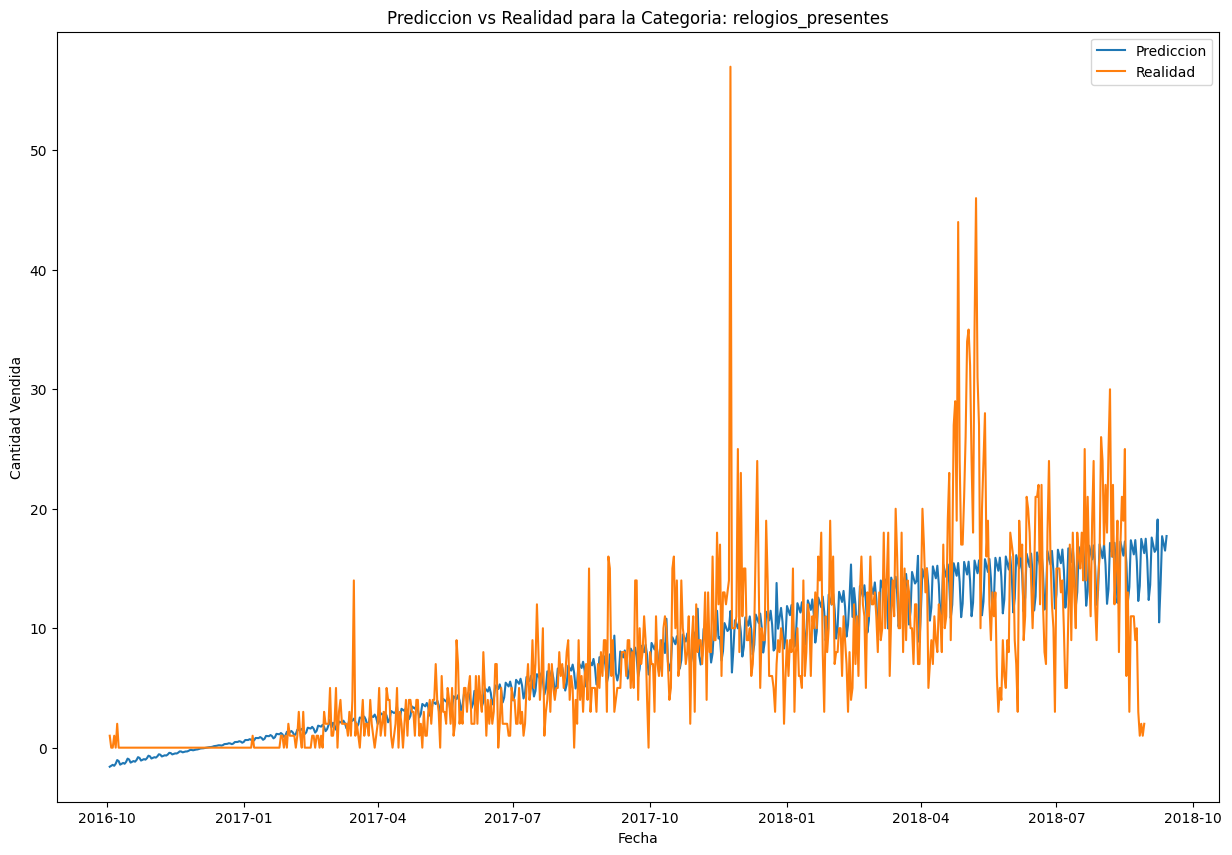

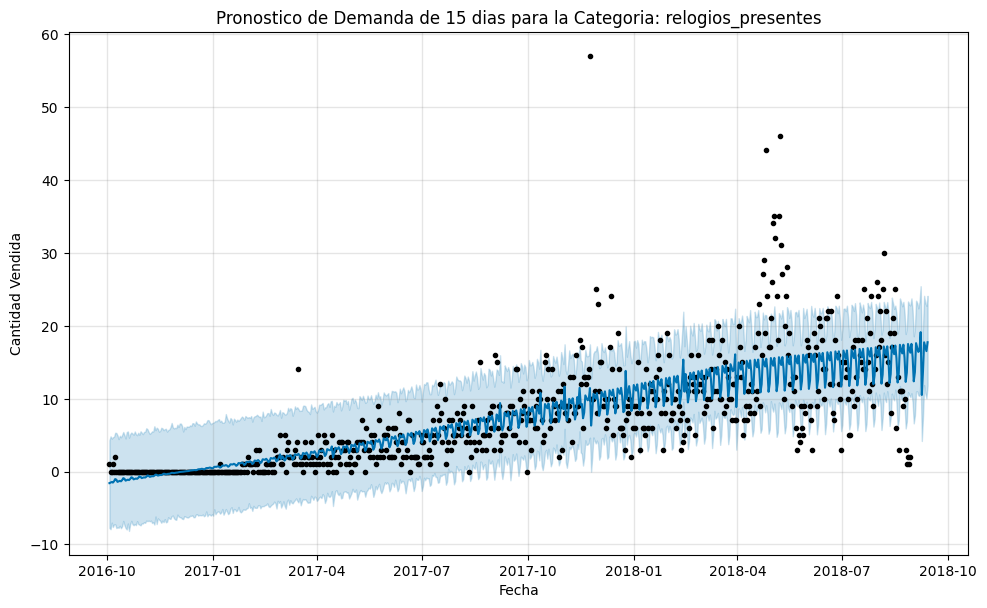

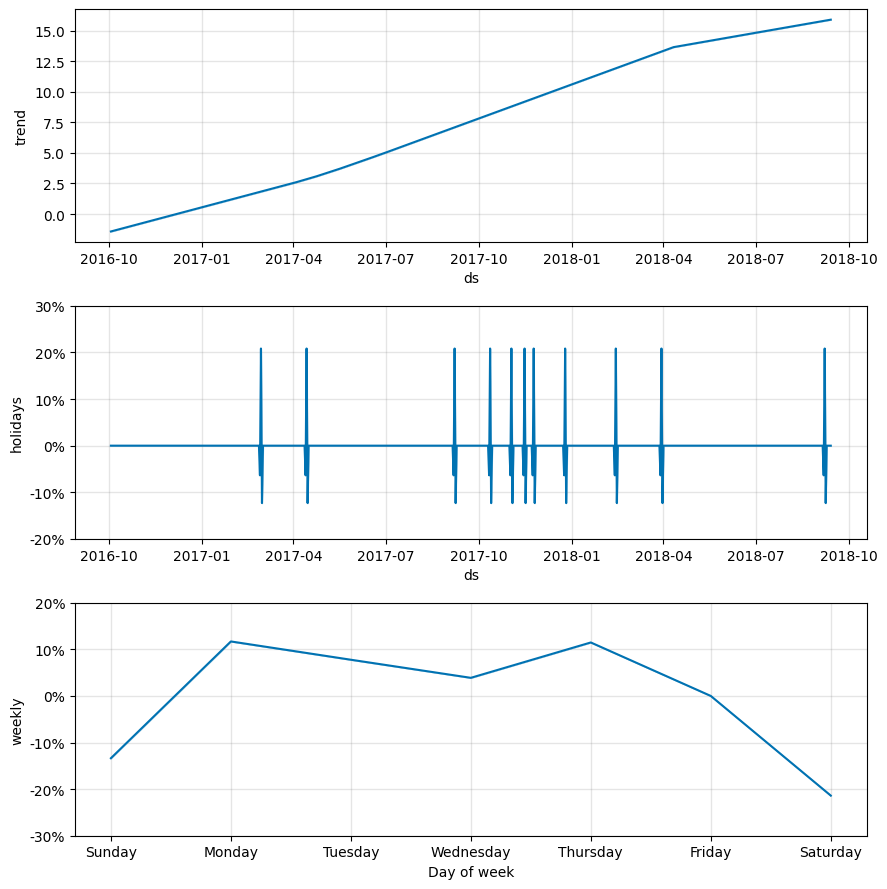

16:02:24 - cmdstanpy - INFO - Chain [1] start processing
16:02:24 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/10 [00:00<?, ?it/s]16:02:25 - cmdstanpy - INFO - Chain [1] start processing
16:02:25 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 1/10 [00:00<00:01,  5.22it/s]16:02:25 - cmdstanpy - INFO - Chain [1] start processing
16:02:25 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 2/10 [00:00<00:01,  4.88it/s]16:02:25 - cmdstanpy - INFO - Chain [1] start processing
16:02:25 - cmdstanpy - INFO - Chain [1] done processing
 30%|███       | 3/10 [00:00<00:01,  5.18it/s]16:02:25 - cmdstanpy - INFO - Chain [1] start processing
16:02:25 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 4/10 [00:00<00:01,  4.95it/s]16:02:26 - cmdstanpy - INFO - Chain [1] start processing
16:02:26 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 5/10 [00:01<00:01,  4.64it/s]16:02:26 - cmdstanpy - INFO - Chain [1] start processi

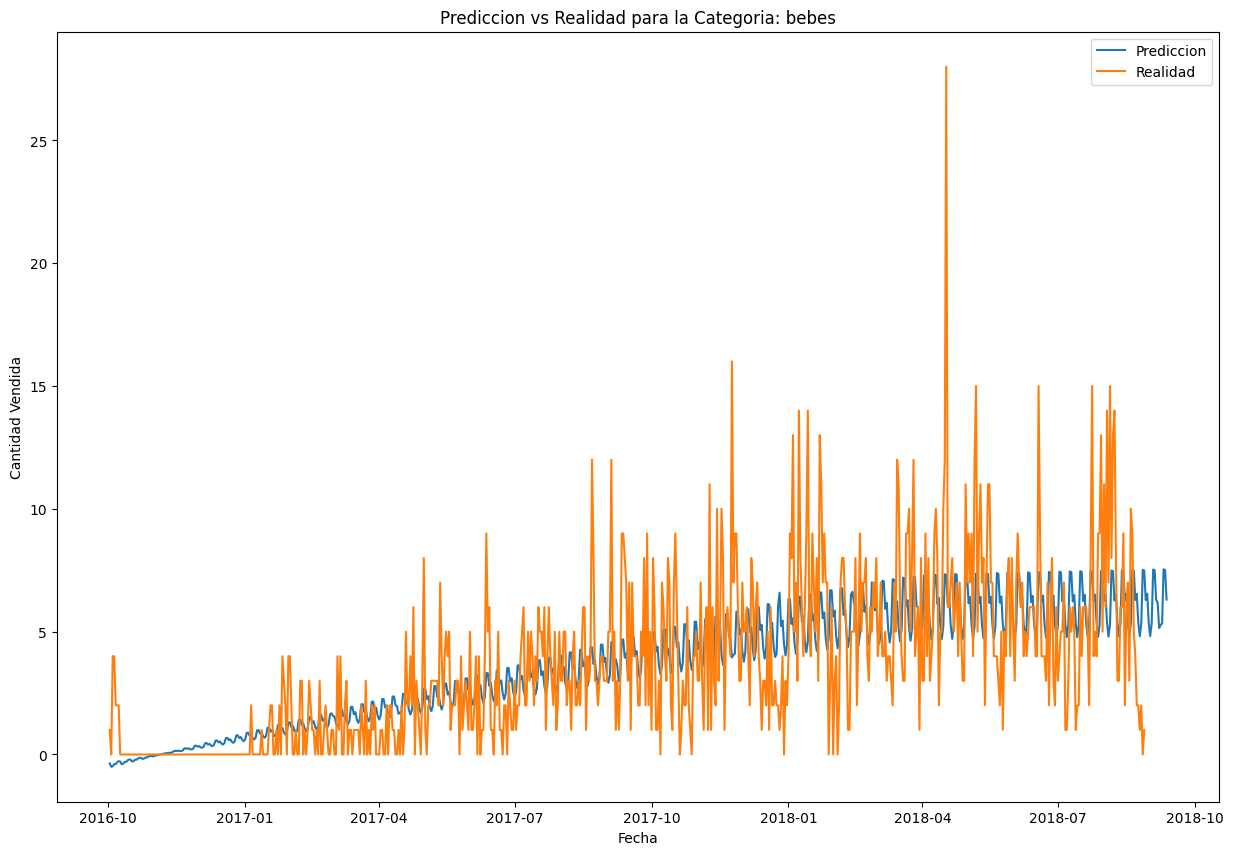

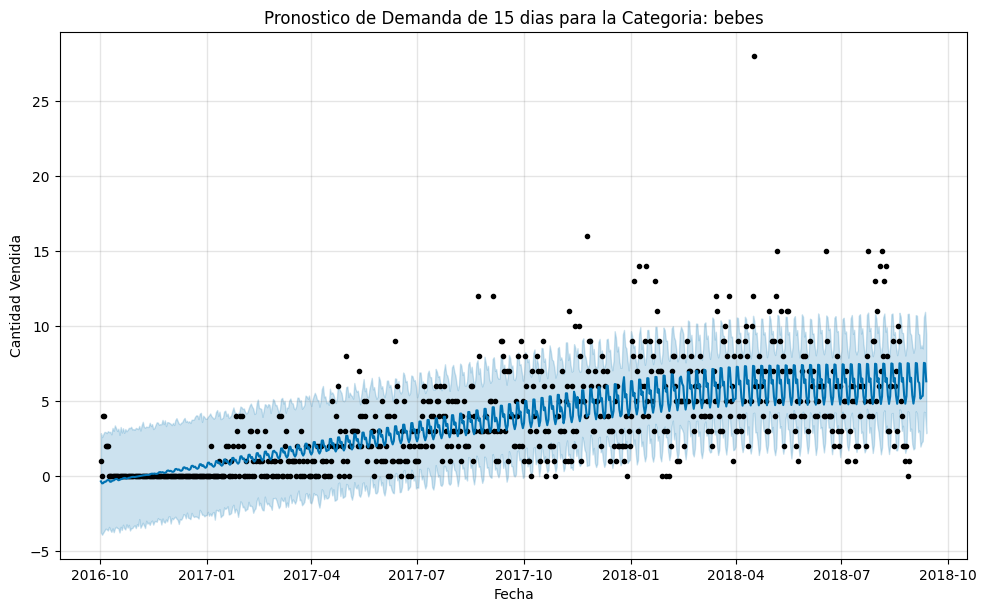

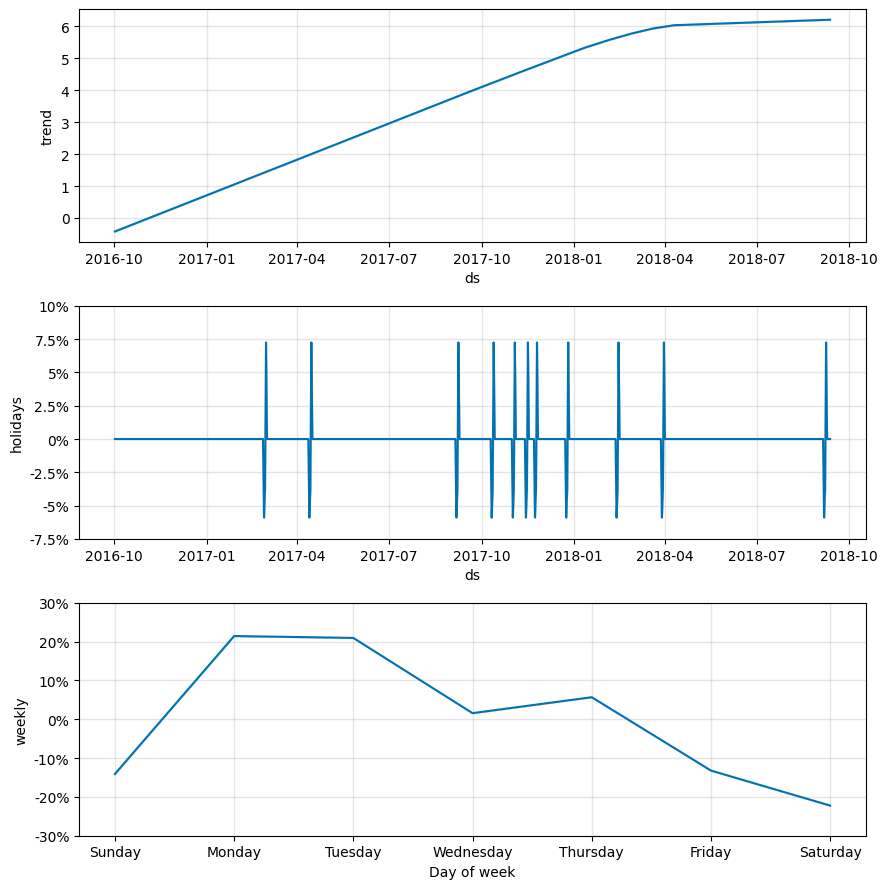

In [14]:
from prophet.diagnostics import cross_validation, performance_metrics


PredictionsA = []
MetricasA = []

for cat in TopA:
  #Construccion del DataFrame 'ds', 'y', 'Categoria de Producto' considerando de los dias festivos de alta demanda comercial de Brasil
  SeriesA = pd.merge(CalendarioA, A, on='ds', how='left')
  SeriesA['y'] = SeriesA['y'].fillna(0)
  SeriesA['Categoria Producto'] = SeriesA['Categoria Producto'].ffill()
  SeriesA

  #Entrenamiento de una Serie de Tiempo para cada Categoria de Alta Rotacion considerando los dias festivos de alta demanda comercial de Brasil
  ProphetA = pd.DataFrame(Cat_Selection(SeriesA, cat))
  model2 = Prophet(
    holidays=holidays, 
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05
  )
  model2.fit(ProphetA)
  future15 = model2.make_future_dataframe(periods=15, freq='D')
  forecast15 = model2.predict(future15)
  PredictionsA.append(forecast15['yhat'].tail(15).sum())
  
  #Metricas de la Serie de Tiempo de Cada Categoria 
  cv = cross_validation(model2, initial='540 days', horizon='16 days' , period= '15 days')
  performance = performance_metrics(cv)
  MetricasA.append(performance)

  plt.figure(figsize=(15, 10))
  plt.plot(forecast15['ds'], forecast15['yhat'], label='Prediccion')
  plt.plot(ProphetA['ds'], ProphetA['y'], label='Realidad')
  plt.title(f'Prediccion vs Realidad para la Categoria: {cat}')

  plt.xlabel('Fecha')
  plt.ylabel('Cantidad Vendida')
  plt.legend()
  plt.show()

  fig_pred = model2.plot(forecast15)
  plt.title(f'Pronostico de Demanda de 15 dias para la Categoria: {cat}')
  plt.xlabel('Fecha')
  plt.ylabel('Cantidad Vendida')
  plt.show()

  fig_comp = model2.plot_components(forecast15) 
  plt.show()

  #Guardamos el Modelo de Cada Categoria para su posterior uso en la Prediccion de Ventas
  dump(model2, open(f'/workspaces/Proyecto_Final_Close-Loop-Intelligence/models/ProphetA_{cat}.pkl', 'wb'))

In [15]:
MetricsA = { TopA: df for TopA, df in zip(TopA, MetricasA) }
for cat, df in MetricsA.items():
    print(f"Metricas para la Categoria: {cat}")
    print(df[['rmse', 'mae']])

Metricas para la Categoria: moveis_decoracao
        rmse       mae
0   7.985559  6.629927
1   5.787131  4.403595
2   7.756575  5.523401
3   7.725639  5.622891
4   6.860184  5.367320
5   5.972503  4.849213
6   5.600495  4.494163
7   6.414990  5.473254
8   7.073467  5.855177
9   6.166732  4.595109
10  6.409711  4.970040
11  5.696964  4.595452
12  5.418553  4.366701
13  6.625507  5.369040
14  8.201700  6.844227
Metricas para la Categoria: esporte_lazer
        rmse       mae
0   3.943034  3.264166
1   4.822378  3.626867
2   4.469373  3.448389
3   5.363741  4.512145
4   5.731346  5.080526
5   5.907791  5.284713
6   5.949032  5.246682
7   6.027337  4.975801
8   6.429001  5.232041
9   6.499844  5.483456
10  7.440673  6.566642
11  7.137526  6.324081
12  5.619228  4.777534
13  6.296180  5.221549
14  6.283264  5.358983
Metricas para la Categoria: beleza_saude
         rmse       mae
0    8.071291  6.658697
1    7.614482  6.431011
2    6.863506  5.972072
3    6.810452  5.023100
4    5.464417  3